# Analysis of Graded Agent Responses - Streamlined Heatmap Analysis

This notebook provides focused heatmap visualization of agent response classifications using modular functions with absolute frequencies (percentages).

## What this notebook does:

### **Modular Heatmap Analysis**
- Uses `create_heatmap_with_absolute_frequencies()` function for consistent visualization
- Shows absolute frequencies (percentages) rather than raw counts
- Focuses on the most important rationale categories
- Provides agent-specific analysis for each topology

### **Chart Types Generated:**
1. **Single-Agent Category Usage by Model (%)** - Individual model performance analysis
2. **Multi-Agent Category Usage by Model (%)** - Group conversation patterns  
3. **Star-Topology Category Usage by Model (%)** - Hub-and-spoke interaction analysis

**Data Source**: Classification files generated by `grade.py` in respective result directories.

In [40]:
# =============================================================================
# MODULAR HEATMAP FUNCTION WITH ABSOLUTE FREQUENCIES AND CATEGORY FILTERING
# =============================================================================
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import json
import os
import glob

# Set BASE_DIR
BASE_DIR = "/Users/ram/Github/wisdom_agents/"

# =============================================================================
# AVAILABLE COLOR PALETTES FOR HEATMAPS
# =============================================================================
AVAILABLE_COLOR_PALETTES = [
    # Sequential (single hue)
    'Blues', 'BuGn', 'BuPu', 'GnBu', 'Greens', 'Greys', 'Oranges', 'OrRd', 
    'PuBu', 'PuBuGn', 'PuRd', 'Purples', 'RdPu', 'Reds', 'YlGn', 'YlGnBu', 
    'YlOrBr', 'YlOrRd',
    
    # Diverging (two hues)
    'BrBG', 'PiYG', 'PRGn', 'PuOr', 'RdBu', 'RdGy', 'RdYlBu', 'RdYlGn', 
    'Spectral', 'coolwarm', 'bwr', 'seismic',
    
    # Qualitative (distinct colors)
    'Accent', 'Dark2', 'Paired', 'Pastel1', 'Pastel2', 'Set1', 'Set2', 'Set3',
    'tab10', 'tab20', 'tab20b', 'tab20c',
    
    # Perceptually uniform
    'viridis', 'plasma', 'inferno', 'magma', 'cividis',
    
    # Matplotlib built-ins
    'hot', 'cool', 'spring', 'summer', 'autumn', 'winter', 'bone', 'copper',
    'pink', 'flag', 'prism', 'ocean', 'gist_earth', 'terrain', 'gist_stern',
    'gnuplot', 'gnuplot2', 'CMRmap', 'cubehelix', 'brg', 'gist_rainbow',
    'rainbow', 'jet', 'nipy_spectral', 'gist_ncar'
]

# =============================================================================
# RATIONALE CATEGORIES DEFINITION
# =============================================================================
VALID_CATEGORY_NAMES = [
    "UTILITARIAN_REASONING",
    "DEONTOLOGICAL_REASONING", 
    "VIRTUE_ETHICS_REASONING",
    "CARE_ETHICS_REASONING",
    "FAIRNESS_JUSTICE_REASONING",
    "AUTHORITY_BASED_REASONING",
    "LOYALTY_BASED_INGROUP_REASONING",
    "LIBERTY_AUTONOMY_REASONING",
    "PURITY_SANCTITY_REASONING",
    "HARM_AVOIDANCE_NON_MALEFICENCE",
    "PEER_PRESSURE_CONVERGENCE",
    "SYCOPHANCY_EXCESSIVE_AGREEMENT",
    "MAINTAINING_DISSENT_INDEPENDENCE",
    "CONVERGENCE_TO_SUPERVISOR_FRAMING",
    "BUILDING_ON_OTHERS_REASONING",
    "EXPLICIT_DISAGREEMENT_COUNTER_ARGUMENT",
    "PRAGMATIC_BALANCING_CONTEXTUAL",
    "RISK_ASSESSMENT_PRECAUTIONARY",
    "SELF_INTEREST_INDIVIDUAL_PRIORITY",
    "LEGALISTIC_POLICY_BASED_REASONING",
    "META_REASONING_CLARIFICATION_FOCUS",
    "ANALOGICAL_CASE_BASED_REASONING",
    "RATIONALE_VAGUE_INCOMPLETE",
    "RATIONALE_CIRCULAR_RESTATING_ANSWER",
    "RATIONALE_TANGENTIAL_IRRELEVANT",
    "NO_CLEAR_RATIONALE_PROVIDED"
]

# =============================================================================
# TOPOLOGY-SPECIFIC DATA LOADING
# =============================================================================
topologies = {
    "Single-Agent": os.path.join(BASE_DIR, "results"),
    "Multi-Agent": os.path.join(BASE_DIR, "results_multi"),
    "Star-Topology": os.path.join(BASE_DIR, "results_multi_star")
}

# =============================================================================
# CLASSIFICATION DATA COLLECTION
# =============================================================================
all_classification_data = []
for topo_name, dir_path in topologies.items():
    if os.path.exists(dir_path):
        for fpath in glob.glob(os.path.join(dir_path, "*_classification.jsonl")):
            try:
                dfj = pd.read_json(fpath, lines=True)
                if "selected_categories" in dfj.columns:
                    dfj['topology'] = topo_name
                    # Add dataset column with the filename (without path and extension)
                    dataset_name = os.path.basename(fpath).replace('_classification.jsonl', '')
                    dfj['dataset'] = dataset_name
                    all_classification_data.append(dfj)
            except Exception as e:
                print(f"Error loading {fpath}: {e}")

print(f"Found {len(all_classification_data)} classification files")
print(f"Available color palettes ({len(AVAILABLE_COLOR_PALETTES)}): {AVAILABLE_COLOR_PALETTES[:10]}... (and {len(AVAILABLE_COLOR_PALETTES)-10} more)")

Found 30 classification files
Available color palettes (72): ['Blues', 'BuGn', 'BuPu', 'GnBu', 'Greens', 'Greys', 'Oranges', 'OrRd', 'PuBu', 'PuBuGn']... (and 62 more)


In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np # For pd.notna

def create_heatmap_with_dual_dfs(
    exploded_data_for_counts: pd.DataFrame, # Input for category counts (numerator)
    unexploded_df_for_group_totals: pd.DataFrame,  # Input for group-specific totals (denominator)
    split_column: str,
    category_column: str = 'selected_categories',
    valid_categories: list = None,
    ordered_categories: list = None,
    title: str = "Category Usage Heatmap",
    cmap: str = 'Blues',
    figsize: tuple = (16, 8),
    top_n_categories: int = 15,
    save=True
):
    """
    Create a heatmap showing absolute frequencies of category usage.
    - Numerator counts come from 'exploded_data_for_counts'.
    - Denominator is the number of original (unexploded) responses specific
      to EACH group in the 'split_column', derived from 'unexploded_df_for_group_totals'.
    - Counts are generated for a base set of categories, and then a final set
      (potentially top_n) is selected for display.
    """
    if not isinstance(exploded_data_for_counts, pd.DataFrame) or exploded_data_for_counts.empty:
        print(f"Input 'exploded_data_for_counts' is not valid or non-empty. For: {title}")
        return None
    if not isinstance(unexploded_df_for_group_totals, pd.DataFrame): # Can be empty if context has no data
        print(f"Input 'unexploded_df_for_group_totals' is not a valid DataFrame. For: {title}")
        return None
        
    if split_column not in exploded_data_for_counts.columns or \
       category_column not in exploded_data_for_counts.columns:
        print(f"Required columns ('{split_column}', '{category_column}') not in 'exploded_data_for_counts'. For: {title}")
        return None
    if split_column not in unexploded_df_for_group_totals.columns:
        print(f"Required column '{split_column}' not in 'unexploded_df_for_group_totals'. For: {title}")
        return None

    df_cleaned_exploded = exploded_data_for_counts.copy()
    df_cleaned_exploded[category_column] = df_cleaned_exploded[category_column].astype(str)
    df_cleaned_exploded = df_cleaned_exploded[
        df_cleaned_exploded[category_column].notna() & \
        (df_cleaned_exploded[category_column].str.lower() != 'nan') & \
        (df_cleaned_exploded[category_column] != '')
    ]

    if df_cleaned_exploded.empty:
        print(f"No data in 'exploded_data_for_counts' after cleaning. For: {title}")
        return None

    # 1. Determine base_categories_for_counting (from exploded_data_for_counts)
    _valid_categories_str_set = set()
    if valid_categories:
        _valid_categories_str_set = {str(c) for c in valid_categories if pd.notna(c) and str(c) != ''}

    if ordered_categories:
        base_categories_for_counting = [str(c) for c in ordered_categories if pd.notna(c) and str(c) != '']
        if not base_categories_for_counting:
            print(f"'ordered_categories' is empty/invalid. For: {title}")
            return None
    elif _valid_categories_str_set:
        base_categories_for_counting = list(_valid_categories_str_set)
    else:
        base_categories_for_counting = df_cleaned_exploded[category_column].unique().tolist()

    if not base_categories_for_counting:
        print(f"No base categories for counting identified. For: {title}")
        return None

    # 2. Calculate Numerator: responses_with_cat from df_cleaned_exploded
    df_for_numerator_counts = df_cleaned_exploded[df_cleaned_exploded[category_column].isin(base_categories_for_counting)]
    if df_for_numerator_counts.empty:
        print(f"No data in 'exploded_data_for_counts' for 'base_categories_for_counting'. For: {title}")
        return None

    responses_with_cat_df = df_for_numerator_counts.groupby(
        [split_column, category_column], observed=True
    ).size().reset_index(name='responses_with_cat')

    if responses_with_cat_df.empty:
        print(f"No category counts (numerator) generated. For: {title}")
        return None

    # 3. Calculate Denominator: total unexploded responses PER GROUP in split_column
    # Ensure unexploded_df_for_group_totals is not empty before groupby
    if unexploded_df_for_group_totals.empty:
        print(f"Info: 'unexploded_df_for_group_totals' is empty. Denominator for all groups will be effectively zero or cause issues. For: {title}")
        # Depending on desired behavior, could return None or try to proceed if some groups might still get a total from elsewhere (not in this logic)
        # For this logic, if this is empty, no group will have a total.
        return None
        
    total_unexploded_responses_per_group = unexploded_df_for_group_totals.groupby(
        split_column, observed=True
    ).size().rename('total_unexploded_in_group')

    if total_unexploded_responses_per_group.empty:
        print(f"Could not determine total unexploded responses per group from 'unexploded_df_for_group_totals'. For: {title}")
        return None
        
    # 4. Merge numerators with group-specific denominators
    freq_df_full_calculations = pd.merge(
        responses_with_cat_df,
        total_unexploded_responses_per_group.reset_index(),
        on=split_column,
        how='left' # Keep all category counts; groups without a total in unexploded will get NaN for denominator
    )

    freq_df_full_calculations = freq_df_full_calculations.dropna(subset=['total_unexploded_in_group'])
    freq_df_full_calculations = freq_df_full_calculations[freq_df_full_calculations['total_unexploded_in_group'] > 0]

    if freq_df_full_calculations.empty:
        print(f"No data for frequency calculation after merging and ensuring positive group totals. For: {title}")
        return None

    freq_df_full_calculations['absolute_freq'] = (
        freq_df_full_calculations['responses_with_cat'] / freq_df_full_calculations['total_unexploded_in_group']
    ) * 100

    # 5. Determine final_categories_for_display
    if ordered_categories:
        final_categories_for_display = base_categories_for_counting # This was already cleaned
    else:
        # Rank categories for display based on their occurrence in df_cleaned_exploded
        # (potentially limited by _valid_categories_str_set if they were provided)
        source_for_display_ranking = df_cleaned_exploded[category_column]
        if _valid_categories_str_set: # If valid_categories were originally provided and non-empty
            temp_source = df_cleaned_exploded[df_cleaned_exploded[category_column].isin(_valid_categories_str_set)][category_column]
            if not temp_source.empty:
                source_for_display_ranking = temp_source
        
        if source_for_display_ranking.empty:
            print(f"Ranking source for display categories is empty. For: {title}")
            return None
            
        category_display_counts = source_for_display_ranking.value_counts()
        final_categories_for_display = category_display_counts.head(top_n_categories).index.tolist()

        if not final_categories_for_display:
            print(f"No categories selected for display via top_n. For: {title}")
            return None

    # 6. Filter freq_df_full_calculations using final_categories_for_display
    freq_df_for_pivot = freq_df_full_calculations[
        freq_df_full_calculations[category_column].isin(final_categories_for_display)
    ]

    if freq_df_for_pivot.empty:
        print(f"Data for pivot is empty after filtering for display categories. For: {title}")
        return None

    # 7. Create pivot table
    pivot_data = freq_df_for_pivot.pivot_table(
        index=split_column,
        columns=category_column,
        values='absolute_freq',
        fill_value=0.0
    )

    if pivot_data.empty:
        print(f"Pivot table is empty after pivoting. For: {title}")
        return None

    cols_in_pivot_to_order = [cat for cat in final_categories_for_display if cat in pivot_data.columns]
    if not cols_in_pivot_to_order:
         print(f"None of 'final_categories_for_display' are in pivot table columns. For: {title}")
         return None # Or allow plotting with pivot_data.columns if some data exists
    pivot_data = pivot_data[cols_in_pivot_to_order]

    # 8. Create heatmap
    try:
        plt.figure(figsize=figsize)
        cbar_label = f'% of Original Responses within each {split_column.replace("_", " ").title()}'
        
        # Calculate appropriate font size based on figure and heatmap dimensions
        num_rows, num_cols = pivot_data.shape
        base_font_size = min(figsize[0] / num_cols * 1.2, figsize[1] / num_rows * 1.5)
        annot_font_size = max(8, min(16, base_font_size))  # Constrain between 8 and 16
        
        sns.heatmap(pivot_data,
                    annot=True,
                    fmt='.1f',
                    cmap=cmap,
                    cbar_kws={'label': cbar_label},
                    linewidths=0.5,
                    annot_kws={'size': annot_font_size, 'weight': 'bold'})
        
        plt.title(title, fontsize=14, pad=20)
        plt.xlabel('Rationale Categories', fontsize=12)
        plt.ylabel(str(split_column).replace('_', ' ').title(), fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
    except Exception as e:
        print(f"Error during heatmap plotting for '{title}': {e}")
        return pivot_data

    if save:
        # Save the heatmap as an image file
        output_dir = os.path.join(BASE_DIR, "heatmaps")
        os.makedirs(output_dir, exist_ok=True)
        output_file = os.path.join(output_dir, f"{title.replace(' ', '_').lower()}.png")
        plt.savefig(output_file)
        print(f"Heatmap saved to {output_file}")
    else:
        print("Heatmap not saved, as 'save' parameter is set to False.")
    plt.show()
    plt.close()  # Close the plot to free memory

    return pivot_data

In [42]:
RATIONALE_CATEGORY_NAMES = [
    "PEER_PRESSURE_CONVERGENCE",
    "SYCOPHANCY_EXCESSIVE_AGREEMENT",
    "MAINTAINING_DISSENT_INDEPENDENCE",
    "CONVERGENCE_TO_SUPERVISOR_FRAMING",
    "BUILDING_ON_OTHERS_REASONING",
    "EXPLICIT_DISAGREEMENT_COUNTER_ARGUMENT",
    "PRAGMATIC_BALANCING_CONTEXTUAL",
    "RISK_ASSESSMENT_PRECAUTIONARY",
    "SELF_INTEREST_INDIVIDUAL_PRIORITY",
    "RATIONALE_CIRCULAR_RESTATING_ANSWER",
]

In [43]:
all_classification_data[-1].columns

Index(['question_id', 'agent_name', 'agent_model', 'message_index',
       'extracted_answer', 'extracted_confidence', 'message_content',
       'is_response_off_topic', 'off_topic_reason', 'selected_categories',
       'row_index', 'error_type', 'error_message', 'classification_item_dict',
       'agent_responses_for_row_count', 'original_question', 'topology',
       'dataset'],
      dtype='object')

In [44]:
all_classification_data[0].columns

Index(['question_id', 'agent_name', 'message_content', 'answer', 'confidence',
       'model_name', 'run_index', 'is_response_off_topic', 'off_topic_reason',
       'selected_categories', 'extracted_answer', 'extracted_confidence',
       'agent_model', 'topology', 'dataset'],
      dtype='object')

In [45]:
# =============================================================================
# HEATMAPS: AGENT-SPECIFIC ANALYSIS (ABSOLUTE FREQUENCIES)
# =============================================================================

# Standardize columns across all classification dataframes before concatenation
for i, df in enumerate(all_classification_data):
    # Add message_index if missing, default to 0
    if 'message_index' not in df.columns:
        df['message_index'] = 0
    
    # Map extracted_answer to answer if needed
    if 'extracted_answer' in df.columns and 'answer' not in df.columns:
        df['answer'] = df['extracted_answer']
    elif 'extracted_answer' in df.columns and 'answer' in df.columns:
        # If both exist, prioritize extracted_answer
        df['answer'] = df['extracted_answer']
    
    # Map extracted_confidence to confidence if needed
    if 'extracted_confidence' in df.columns and 'confidence' not in df.columns:
        df['confidence'] = df['extracted_confidence']
    elif 'extracted_confidence' in df.columns and 'confidence' in df.columns:
        # If both exist, prioritize extracted_confidence
        df['confidence'] = df['extracted_confidence']
    
    # Map agent_model to model_name if needed
    if 'agent_model' in df.columns and 'model_name' not in df.columns:
        df['model_name'] = df['agent_model']
    elif 'agent_model' in df.columns and 'model_name' in df.columns:
        # If both exist, prioritize agent_model
        df['model_name'] = df['agent_model']

print(f"Standardized {len(all_classification_data)} classification dataframes")

# Combine all classification data
combined_df = pd.concat(all_classification_data, ignore_index=True)

# Create exploded dataframe for accurate category counting
exploded_df = combined_df.explode("selected_categories")
exploded_df = exploded_df[exploded_df['selected_categories'].notna()]

# Add question classification columns based on question_id ranges
def classify_question(question_id):
    if 1 <= question_id <= 40:
        return False, 'IH'
    elif 41 <= question_id <= 90:
        return False, 'IB'
    elif 101 <= question_id <= 140:
        return True, 'IH'
    elif 141 <= question_id <= 190:
        return True, 'IB'
    else:
        return None, None

# Apply classification to both dataframes
classification_results = combined_df['question_id'].apply(classify_question)
combined_df['question_inverted'] = [result[0] for result in classification_results]
combined_df['question_category'] = [result[1] for result in classification_results]

exploded_classification_results = exploded_df['question_id'].apply(classify_question)
exploded_df['question_inverted'] = [result[0] for result in exploded_classification_results]
exploded_df['question_category'] = [result[1] for result in exploded_classification_results]

# Add group classification columns based on dataset naming patterns
def classify_group(dataset_name):
    """
    Classify group characteristics from dataset name.
    Returns: (group_inverted, group_type, group_model, group_evil)
    """
    dataset = str(dataset_name).lower()
    
    # Determine if inverted
    group_inverted = 'inverted' in dataset
    
    # Determine if evil
    group_evil = 'evil' in dataset
    
    # Determine group type
    if dataset.startswith('single_'):
        group_type = 'single'
    elif '_ring_' in dataset:
        group_type = 'ring'
    elif '_star_' in dataset:
        group_type = 'star'
    else:
        group_type = 'unknown'
    
    # Extract model name
    group_model = 'unknown'
    
    # Model extraction patterns
    if 'openai' in dataset or 'gpt' in dataset:
        group_model = 'openai'
    elif 'anthropic' in dataset or 'claude' in dataset:
        group_model = 'claude'
    elif 'google' in dataset or 'gemini' in dataset:
        group_model = 'google'
    elif 'meta-llama' in dataset or 'llama' in dataset:
        group_model = 'llama'
    elif 'qwen' in dataset:
        group_model = 'qwen'
    elif 'deepseek' in dataset:
        group_model = 'deepseek'
    elif 'mistral' in dataset:
        group_model = 'mistral'
    elif 'hetero' in dataset:
        group_model = 'mixed'
    
    return group_inverted, group_type, group_model, group_evil

# Apply group classification to both dataframes
group_results = combined_df['dataset'].apply(classify_group)
combined_df['group_inverted'] = [result[0] for result in group_results]
combined_df['group_type'] = [result[1] for result in group_results]
combined_df['group_model'] = [result[2] for result in group_results]
combined_df['group_evil'] = [result[3] for result in group_results]

exploded_group_results = exploded_df['dataset'].apply(classify_group)
exploded_df['group_inverted'] = [result[0] for result in exploded_group_results]
exploded_df['group_type'] = [result[1] for result in exploded_group_results]
exploded_df['group_model'] = [result[2] for result in exploded_group_results]
exploded_df['group_evil'] = [result[3] for result in exploded_group_results]

print(f"Added question classification columns:")
print(f"Question inverted distribution: {combined_df['question_inverted'].value_counts()}")
print(f"Question category distribution: {combined_df['question_category'].value_counts()}")

print(f"\nAdded group classification columns:")
print(f"Group inverted distribution: {combined_df['group_inverted'].value_counts()}")
print(f"Group type distribution: {combined_df['group_type'].value_counts()}")
print(f"Group model distribution: {combined_df['group_model'].value_counts()}")
print(f"Group evil distribution: {combined_df['group_evil'].value_counts()}")

print(f"\nExploded dataframe created with {len(exploded_df)} category instances from {len(combined_df)} responses")

Standardized 30 classification dataframes
Added question classification columns:
Question inverted distribution: question_inverted
False    256843
True     213797
Name: count, dtype: int64
Question category distribution: question_category
IB    262191
IH    208449
Name: count, dtype: int64

Added group classification columns:
Group inverted distribution: group_inverted
False    256843
True     213797
Name: count, dtype: int64
Group type distribution: group_type
ring      362755
star       94925
single     12960
Name: count, dtype: int64
Group model distribution: group_model
openai      122946
qwen         79726
deepseek     54107
google       54011
claude       54008
llama        53992
mixed        51850
Name: count, dtype: int64
Group evil distribution: group_evil
False    453371
True      17269
Name: count, dtype: int64

Exploded dataframe created with 927376 category instances from 470640 responses
Added question classification columns:
Question inverted distribution: question_inver

Total classification records: 470640
Total exploded category instances: 927376
Topologies found: ['Single-Agent' 'Multi-Agent' 'Star-Topology']

1. Single-Agent Category Usage by Model (Inverted False) (%)
Heatmap saved to /Users/ram/Github/wisdom_agents/heatmaps/single-agent:_rationale_category_usage_by_model_(inverted_false)_(%_of_model_responses).png
Heatmap saved to /Users/ram/Github/wisdom_agents/heatmaps/single-agent:_rationale_category_usage_by_model_(inverted_false)_(%_of_model_responses).png


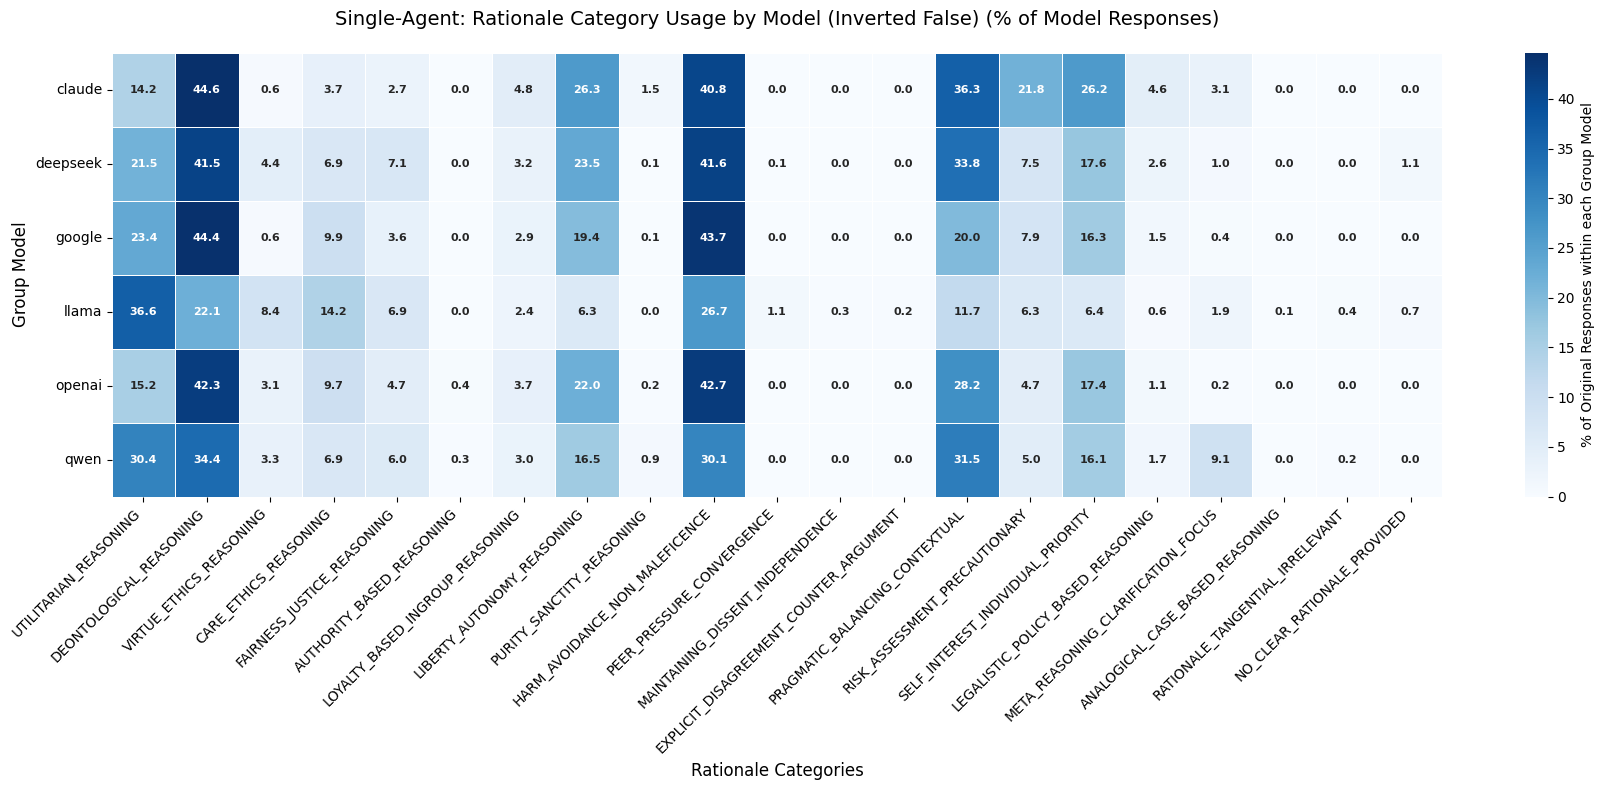


2. Single-Agent Category Usage by Model (Inverted True) (%)
Heatmap saved to /Users/ram/Github/wisdom_agents/heatmaps/single-agent:_rationale_category_usage_by_model_(inverted_true)_(%_of_model_responses).png
Heatmap saved to /Users/ram/Github/wisdom_agents/heatmaps/single-agent:_rationale_category_usage_by_model_(inverted_true)_(%_of_model_responses).png


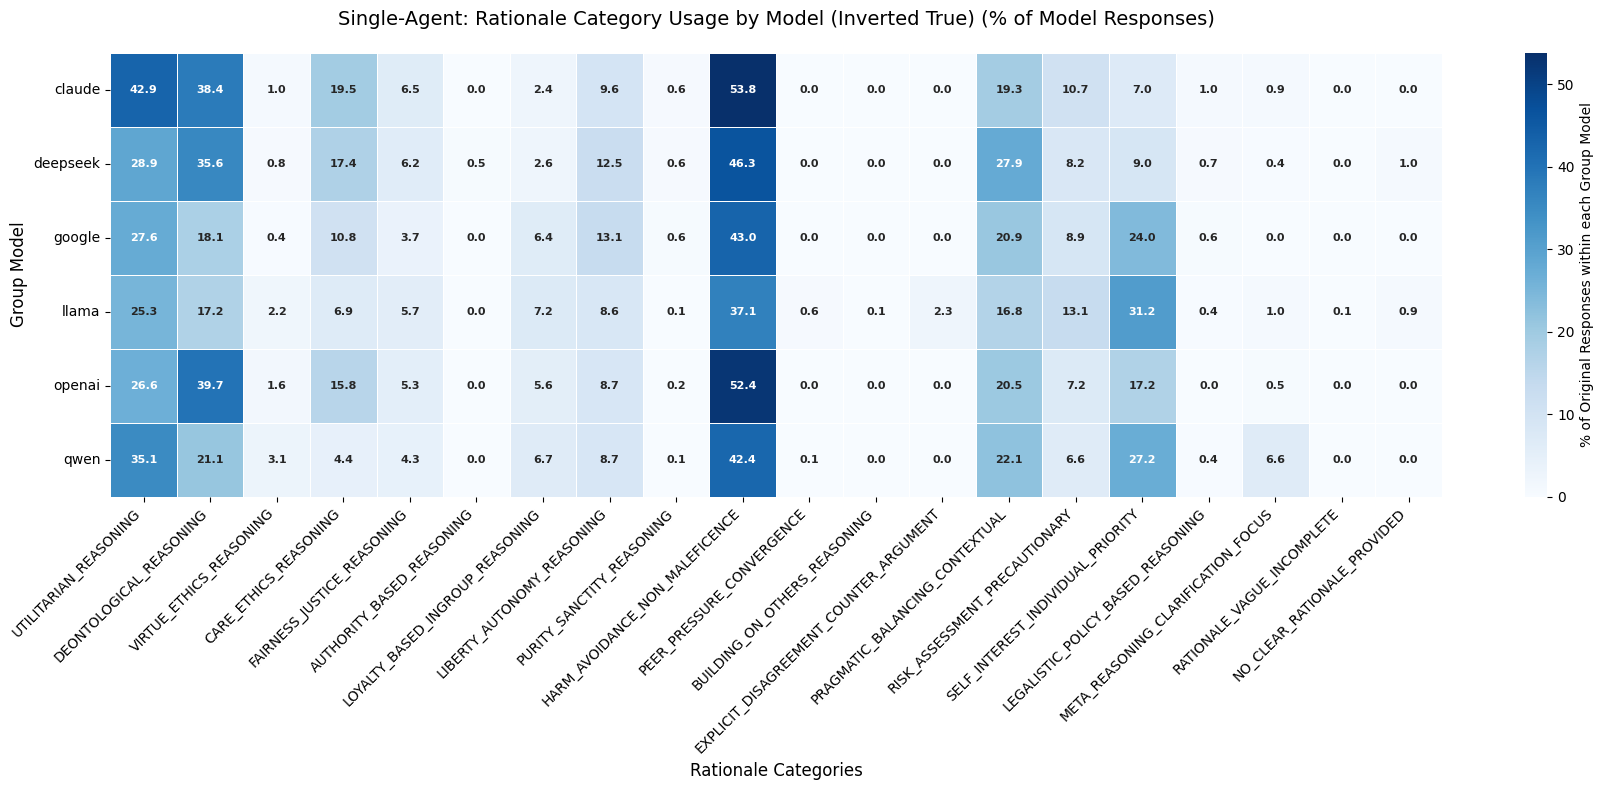


3. Ring Usage by Model (Inverted False) (%)
Heatmap saved to /Users/ram/Github/wisdom_agents/heatmaps/multi-agent:_rationale_category_usage_by_model_(inverted_false)_(%_of_model_responses).png
Heatmap saved to /Users/ram/Github/wisdom_agents/heatmaps/multi-agent:_rationale_category_usage_by_model_(inverted_false)_(%_of_model_responses).png


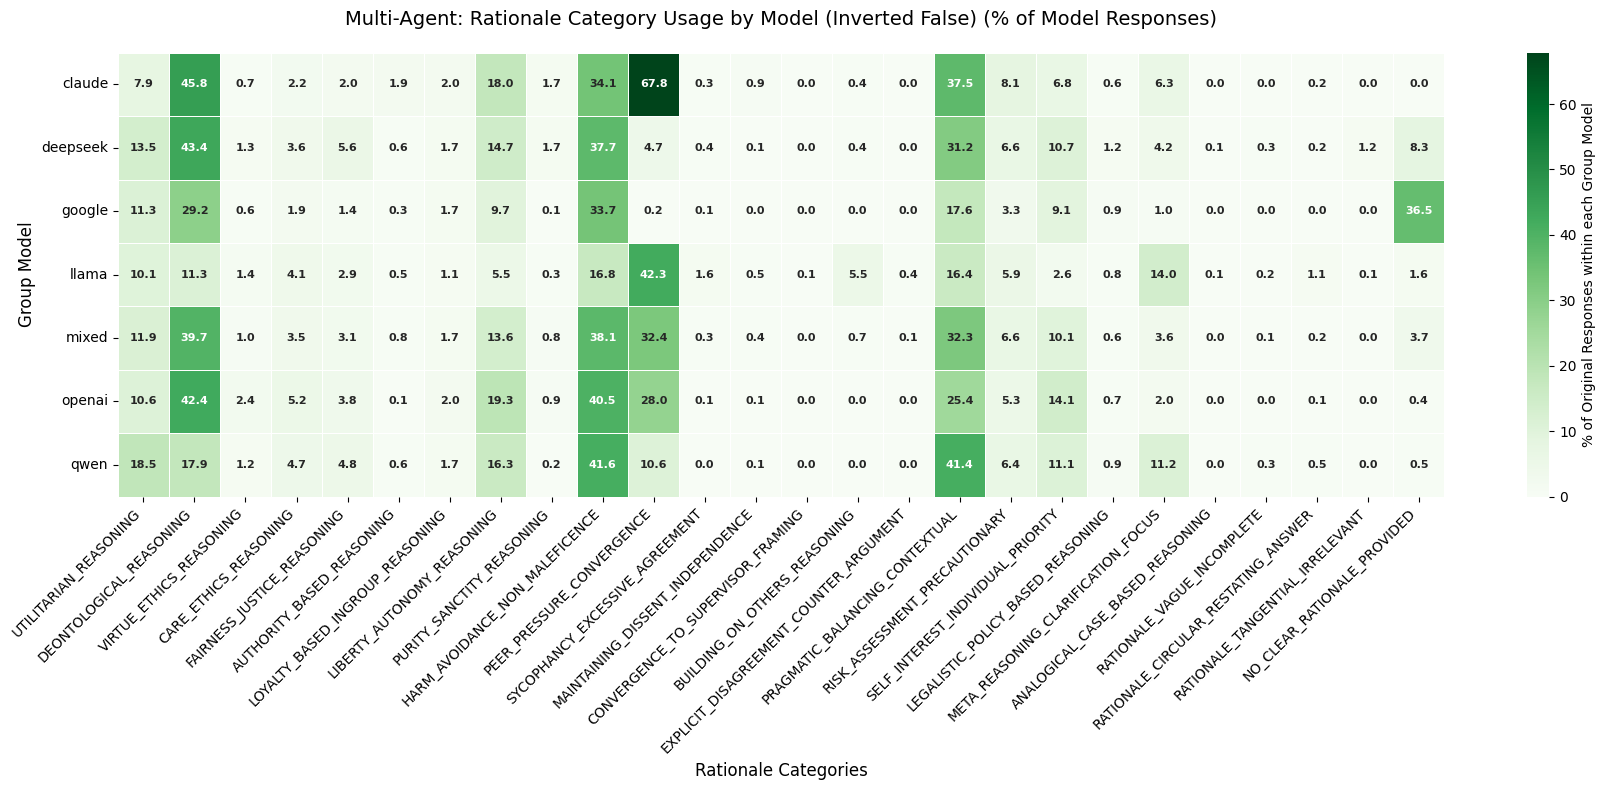


4. Ring Usage by Model (Inverted True) (%)
Heatmap saved to /Users/ram/Github/wisdom_agents/heatmaps/multi-agent:_rationale_category_usage_by_model_(inverted_true)_(%_of_model_responses).png
Heatmap saved to /Users/ram/Github/wisdom_agents/heatmaps/multi-agent:_rationale_category_usage_by_model_(inverted_true)_(%_of_model_responses).png


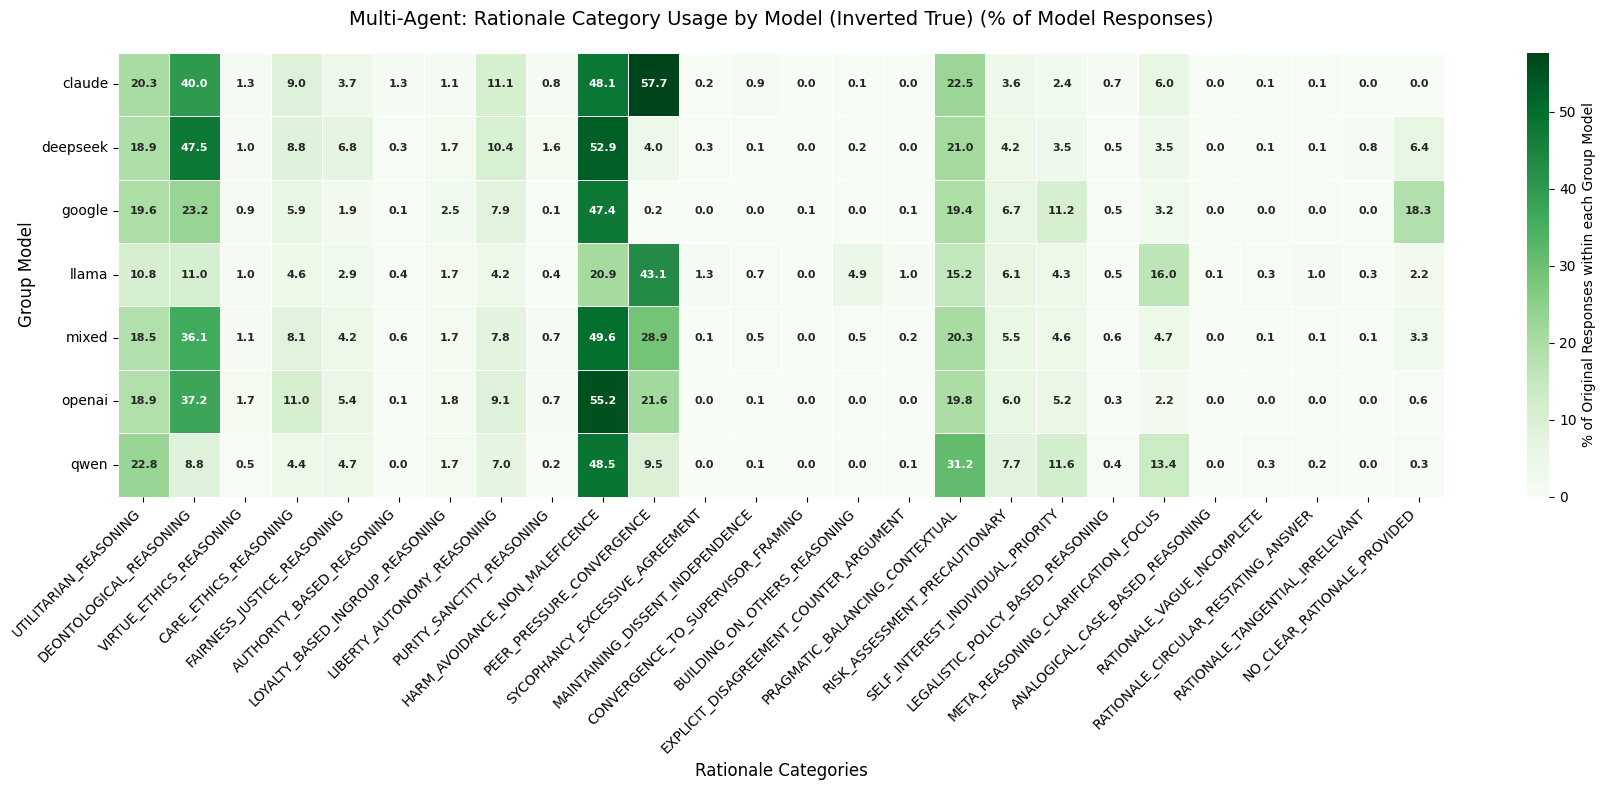


5. Star Usage by Inversion (%)

Heatmap saved to /Users/ram/Github/wisdom_agents/heatmaps/multi-agent:_rationale_category_usage_by_model_(inverted_false)_(%_of_model_responses).png
Heatmap saved to /Users/ram/Github/wisdom_agents/heatmaps/multi-agent:_rationale_category_usage_by_model_(inverted_false)_(%_of_model_responses).png


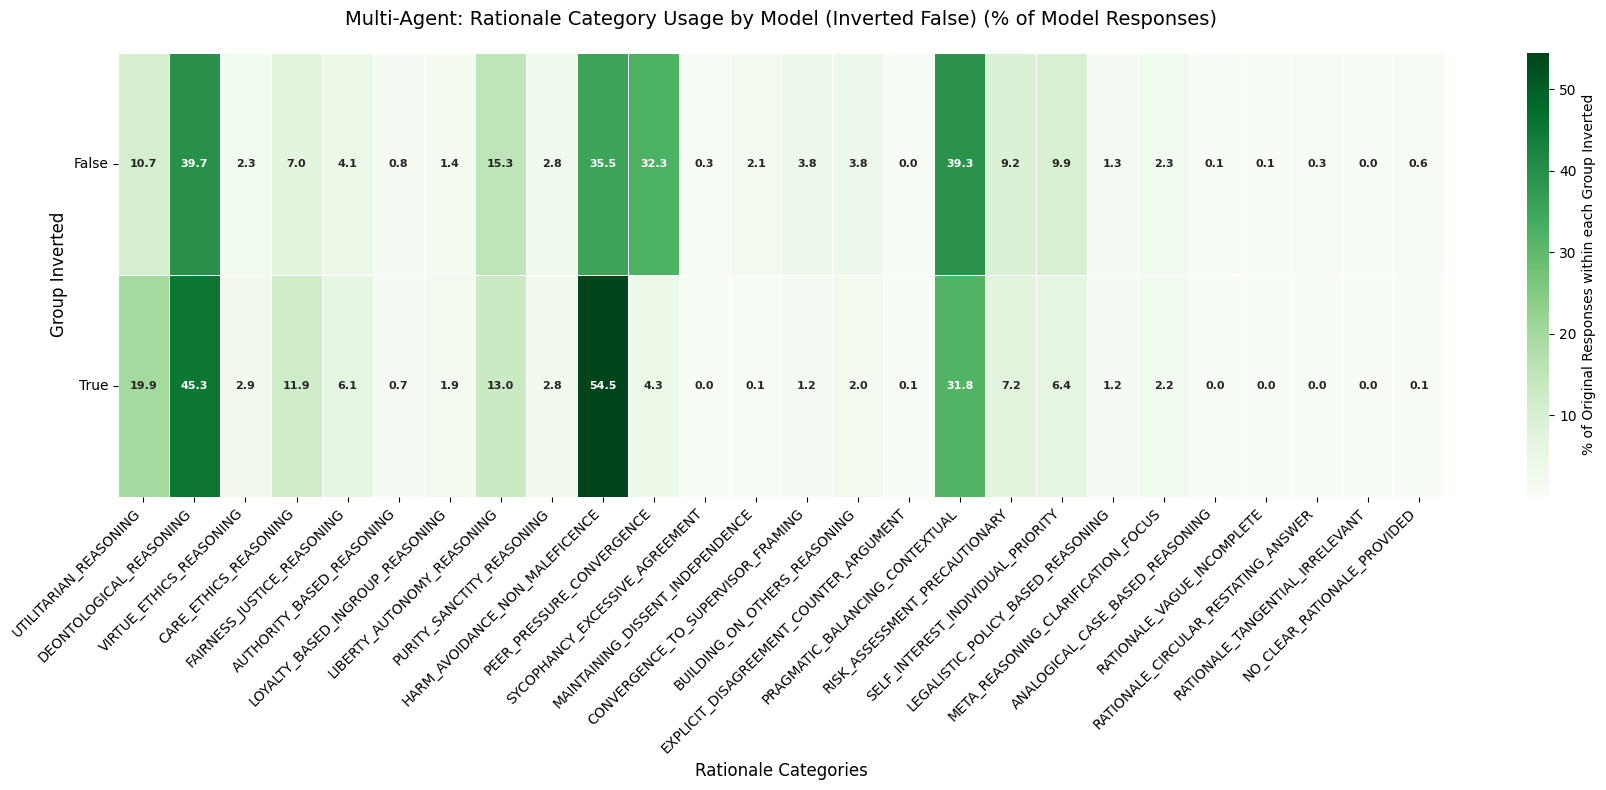


6. Star Usage by Evil (%)
Heatmap saved to /Users/ram/Github/wisdom_agents/heatmaps/multi-agent:_rationale_category_usage_by_model_(inverted_false)_(%_of_model_responses).png
Heatmap saved to /Users/ram/Github/wisdom_agents/heatmaps/multi-agent:_rationale_category_usage_by_model_(inverted_false)_(%_of_model_responses).png


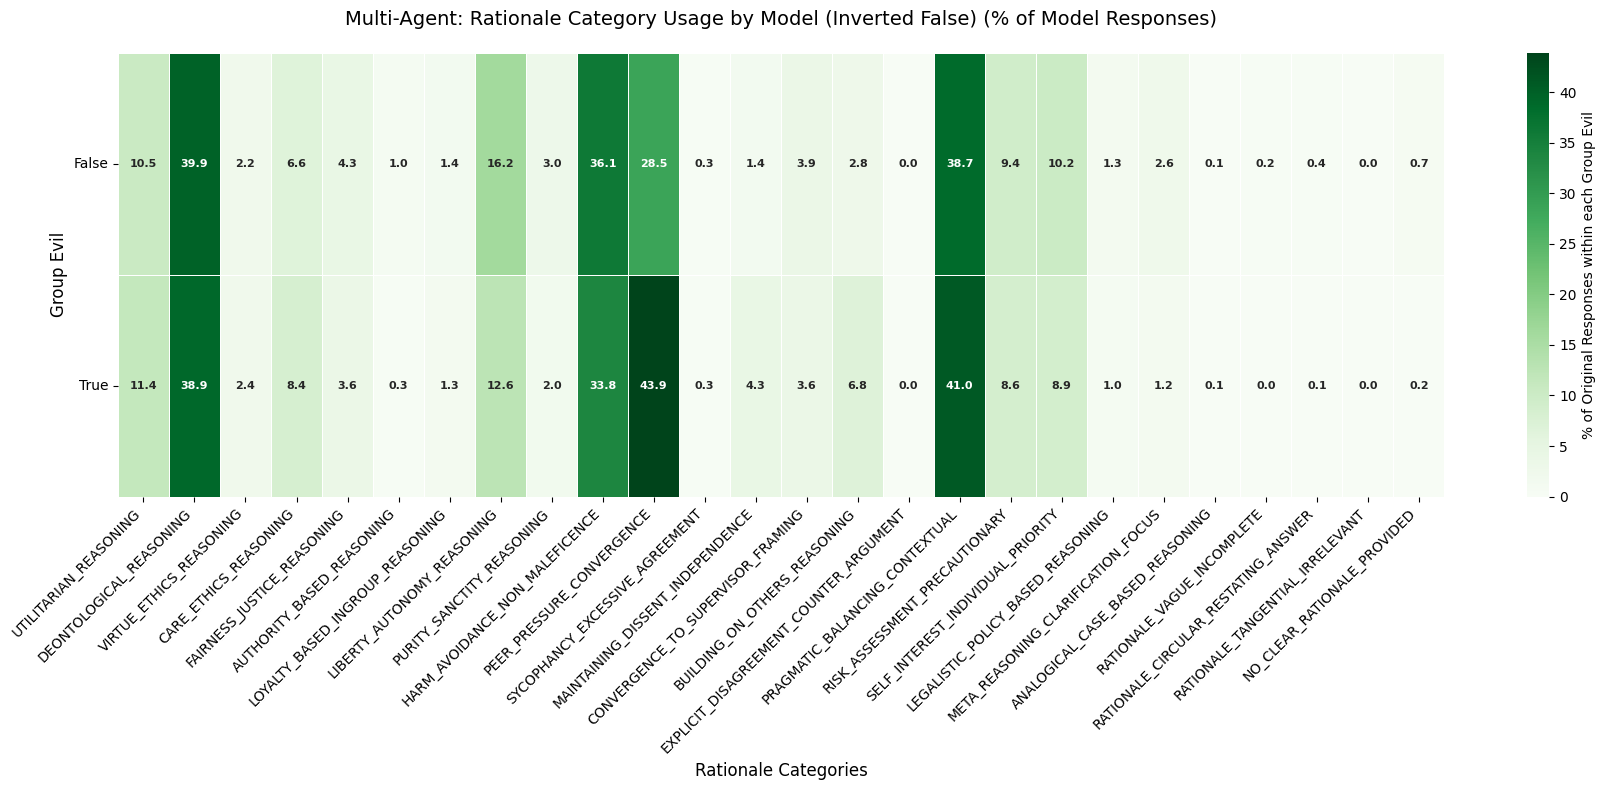


7. Inverted vs Not Inverted (remove Evil) (%)
Heatmap saved to /Users/ram/Github/wisdom_agents/heatmaps/inverted_vs_not_inverted_(remove_evil)_(%).png
Heatmap saved to /Users/ram/Github/wisdom_agents/heatmaps/inverted_vs_not_inverted_(remove_evil)_(%).png


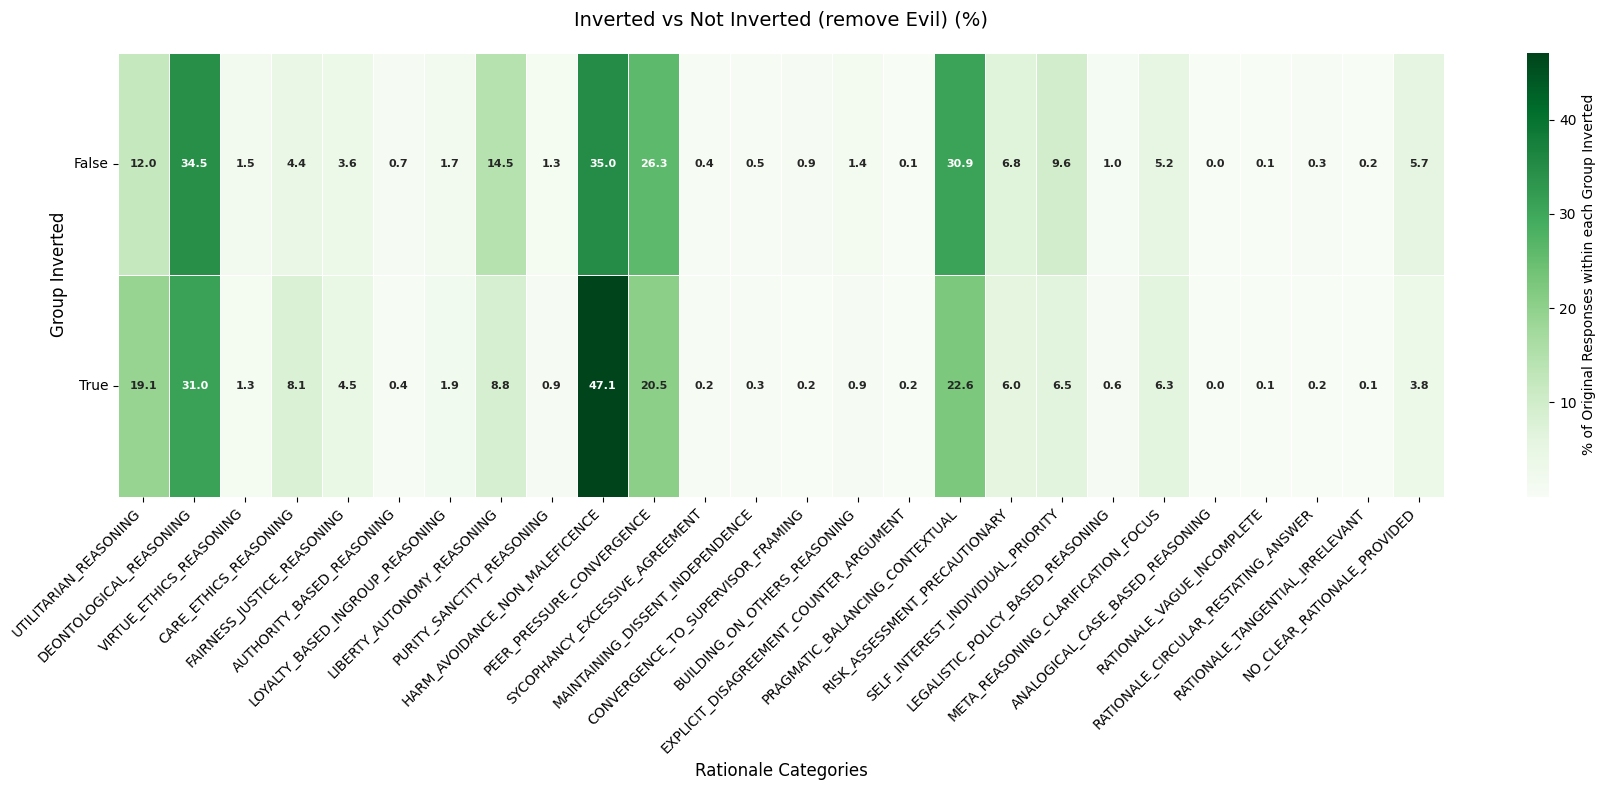

selected_categories,UTILITARIAN_REASONING,DEONTOLOGICAL_REASONING,VIRTUE_ETHICS_REASONING,CARE_ETHICS_REASONING,FAIRNESS_JUSTICE_REASONING,AUTHORITY_BASED_REASONING,LOYALTY_BASED_INGROUP_REASONING,LIBERTY_AUTONOMY_REASONING,PURITY_SANCTITY_REASONING,HARM_AVOIDANCE_NON_MALEFICENCE,...,PRAGMATIC_BALANCING_CONTEXTUAL,RISK_ASSESSMENT_PRECAUTIONARY,SELF_INTEREST_INDIVIDUAL_PRIORITY,LEGALISTIC_POLICY_BASED_REASONING,META_REASONING_CLARIFICATION_FOCUS,ANALOGICAL_CASE_BASED_REASONING,RATIONALE_VAGUE_INCOMPLETE,RATIONALE_CIRCULAR_RESTATING_ANSWER,RATIONALE_TANGENTIAL_IRRELEVANT,NO_CLEAR_RATIONALE_PROVIDED
group_inverted,,,,,,,,,,,,,,,,,,,,,
False,11.972919,34.500405,1.504337,4.376101,3.606401,0.725454,1.685492,14.504913,1.289789,35.032182,...,30.890247,6.835049,9.629175,0.970473,5.189628,0.042993,0.137744,0.319734,0.15611,5.686761
True,19.077443,31.036450,1.296089,8.084304,4.468725,0.422831,1.861111,8.842968,0.899919,47.089529,...,22.625201,5.992600,6.531897,0.592618,6.260612,0.018242,0.099159,0.191771,0.14453,3.806414


In [46]:
print(f"Total classification records: {len(combined_df)}")
print(f"Total exploded category instances: {len(exploded_df)}")
print(f"Topologies found: {combined_df['topology'].unique()}")

# plot across all group_inverted, group_type, group_model, group_evil

"""# HEATMAP 1: Single-Agent Category Usage by Model
single_agent_data_exploded = exploded_df[exploded_df['topology'] == 'Single-Agent']
single_agent_data = combined_df[combined_df['topology'] == 'Single-Agent']

print("\n1. Single-Agent Category Usage by Model (%)")
create_heatmap_with_dual_dfs(
    exploded_data_for_counts=single_agent_data_exploded,
    unexploded_df_for_group_totals=single_agent_data,
    split_column='agent_model',
    title='Single-Agent: Rationale Category Usage by Model (% of Model Responses)',
    cmap='Blues',
    figsize=(18, 8),
    ordered_categories=VALID_CATEGORY_NAMES
)

# HEATMAP 2: Multi-Agent Category Usage by Model
multi_agent_data_exploded = exploded_df[exploded_df['topology'] == 'Multi-Agent']
multi_agent_data = combined_df[combined_df['topology'] == 'Multi-Agent']

print("\n2. Multi-Agent Category Usage by Model (%)")
create_heatmap_with_dual_dfs(
    exploded_data_for_counts=multi_agent_data_exploded,
    unexploded_df_for_group_totals=multi_agent_data,
    split_column='agent_model',
    title='Multi-Agent: Rationale Category Usage by Model (% of Model Responses)',
    cmap='Greens',
    figsize=(18, 8),
    ordered_categories=VALID_CATEGORY_NAMES
)"""

# group agent single with agent category with not inverted by model
single_agent_data_exploded = exploded_df[
    (exploded_df['group_type'] == 'single') &  
    (exploded_df['group_inverted'] == False) & 
    (exploded_df['group_model'].notna())
]
single_agent_data = combined_df[
    (combined_df['group_type'] == 'single') &  
    (combined_df['group_inverted'] == False) & 
    (combined_df['group_model'].notna())
]
print("\n1. Single-Agent Category Usage by Model (Inverted False) (%)")
create_heatmap_with_dual_dfs(
    exploded_data_for_counts=single_agent_data_exploded,
    unexploded_df_for_group_totals=single_agent_data,
    split_column='group_model',
    title='Single-Agent: Rationale Category Usage by Model (Inverted False) (% of Model Responses)',
    cmap='Blues',
    figsize=(18, 8),
    ordered_categories=VALID_CATEGORY_NAMES
)

# group agent single with agent category with inverted by model
single_agent_data_exploded = exploded_df[
    (exploded_df['group_type'] == 'single') &  
    (exploded_df['group_inverted'] == True) & 
    (exploded_df['group_model'].notna())
]
single_agent_data = combined_df[
    (combined_df['group_type'] == 'single') &  
    (combined_df['group_inverted'] == True) & 
    (combined_df['group_model'].notna())
]
print("\n2. Single-Agent Category Usage by Model (Inverted True) (%)")
create_heatmap_with_dual_dfs(
    exploded_data_for_counts=single_agent_data_exploded,
    unexploded_df_for_group_totals=single_agent_data,
    split_column='group_model',
    title='Single-Agent: Rationale Category Usage by Model (Inverted True) (% of Model Responses)',
    cmap='Blues',
    figsize=(18, 8),
    ordered_categories=VALID_CATEGORY_NAMES
)

# ring with agent model with not inverted by model
multi_agent_data_exploded = exploded_df[
    (exploded_df['group_type'] == 'ring') &  
    (exploded_df['group_inverted'] == False) & 
    (exploded_df['group_model'].notna())
]
multi_agent_data = combined_df[
    (combined_df['group_type'] == 'ring') &  
    (combined_df['group_inverted'] == False) & 
    (combined_df['group_model'].notna())
]
print("\n3. Ring Usage by Model (Inverted False) (%)")
create_heatmap_with_dual_dfs(
    exploded_data_for_counts=multi_agent_data_exploded,
    unexploded_df_for_group_totals=multi_agent_data,
    split_column='group_model',
    title='Multi-Agent: Rationale Category Usage by Model (Inverted False) (% of Model Responses)',
    cmap='Greens',
    figsize=(18, 8),
    ordered_categories=VALID_CATEGORY_NAMES
)

# ring with agent model with inverted by model
multi_agent_data_exploded = exploded_df[
    (exploded_df['group_type'] == 'ring') &  
    (exploded_df['group_inverted'] == True) & 
    (exploded_df['group_model'].notna())
]
multi_agent_data = combined_df[
    (combined_df['group_type'] == 'ring') &  
    (combined_df['group_inverted'] == True) & 
    (combined_df['group_model'].notna())
]

print("\n4. Ring Usage by Model (Inverted True) (%)")
create_heatmap_with_dual_dfs(
    exploded_data_for_counts=multi_agent_data_exploded,
    unexploded_df_for_group_totals=multi_agent_data,
    split_column='group_model',
    title='Multi-Agent: Rationale Category Usage by Model (Inverted True) (% of Model Responses)',
    cmap='Greens',
    figsize=(18, 8),
    ordered_categories=VALID_CATEGORY_NAMES
)

# star with agent model with and with not inversion
print("\n5. Star Usage by Inversion (%)")
multi_agent_data_exploded = exploded_df[
    (exploded_df['group_type'] == 'star')
]
multi_agent_data = combined_df[
    (combined_df['group_type'] == 'star')
]
create_heatmap_with_dual_dfs(
    exploded_data_for_counts=multi_agent_data_exploded,
    unexploded_df_for_group_totals=multi_agent_data,
    split_column='group_inverted',
    title='Multi-Agent: Rationale Category Usage by Model (Inverted False) (% of Model Responses)',
    cmap='Greens',
    figsize=(18, 8),
    ordered_categories=VALID_CATEGORY_NAMES
)

# star with / without evil
print("\n6. Star Usage by Evil (%)")
multi_agent_data_exploded = exploded_df[
    (exploded_df['group_type'] == 'star' ) &
    (exploded_df['group_inverted'] == False)
]
multi_agent_data = combined_df[
    (combined_df['group_type'] == 'star') &
    (combined_df['group_inverted'] == False)
]
create_heatmap_with_dual_dfs(
    exploded_data_for_counts=multi_agent_data_exploded,
    unexploded_df_for_group_totals=multi_agent_data,
    split_column='group_evil',
    title='Multi-Agent: Rationale Category Usage by Model (Inverted False) (% of Model Responses)',
    cmap='Greens',
    figsize=(18, 8),
    ordered_categories=VALID_CATEGORY_NAMES
)

# star with / without evil
print("\n7. Inverted vs Not Inverted (remove Evil) (%)")
multi_agent_data_exploded = exploded_df[
    (exploded_df['group_evil'] == False)
]
multi_agent_data = combined_df[
    (combined_df['group_evil'] == False)
]

create_heatmap_with_dual_dfs(
    exploded_data_for_counts=multi_agent_data_exploded,
    unexploded_df_for_group_totals=multi_agent_data,
    split_column='group_inverted',
    title='Inverted vs Not Inverted (remove Evil) (%)',
    cmap='Greens',
    figsize=(18, 8),
    ordered_categories=VALID_CATEGORY_NAMES
)

In [47]:
# get claude model runs in ring homo and hetero
print("Claude homo vs hetero")


Claude homo vs hetero


In [48]:
def classify_group_custom_type(group_type, group_model):
    """
    Classify group custom type based on group_type and group_model.
    Returns: group_custom_type
    """
    if group_type == 'single':
        return 'single'
    elif group_type == 'ring':
        if group_model == 'mixed':
            return 'ring_hetero'
        else:
            return 'ring_homo'
    elif group_type == 'star':
        return 'star'
    else:
        return 'unknown'

# Apply group custom type classification to both dataframes
combined_df['group_custom_type'] = combined_df.apply(
    lambda row: classify_group_custom_type(row['group_type'], row['group_model']), 
    axis=1
)

exploded_df['group_custom_type'] = exploded_df.apply(
    lambda row: classify_group_custom_type(row['group_type'], row['group_model']), 
    axis=1
)

print(f"Group custom type distribution in combined_df:")
print(combined_df['group_custom_type'].value_counts())

print(f"\nGroup custom type distribution in exploded_df:")
print(exploded_df['group_custom_type'].value_counts())

# Create custom combined dataframe - filter out group_evil data
custom_combined_df = combined_df[combined_df['group_evil'] == False].copy()
custom_exploded_df = exploded_df[exploded_df['group_evil'] == False].copy()

print(f"\nCustom dataframes created with group_custom_type column (filtering out group_evil)")
print(f"Original combined_df shape: {combined_df.shape}")
print(f"Custom combined_df shape (no evil): {custom_combined_df.shape}")
print(f"Original exploded_df shape: {exploded_df.shape}")
print(f"Custom exploded_df shape (no evil): {custom_exploded_df.shape}")

Group custom type distribution in combined_df:
group_custom_type
ring_homo      310905
star            94925
ring_hetero     51850
single          12960
Name: count, dtype: int64

Group custom type distribution in exploded_df:
group_custom_type
ring_homo      585590
star           211861
ring_hetero    104627
single          25298
Name: count, dtype: int64

Custom dataframes created with group_custom_type column (filtering out group_evil)
Original combined_df shape: (470640, 30)
Custom combined_df shape (no evil): (453371, 30)
Original exploded_df shape: (927376, 30)
Custom exploded_df shape (no evil): (886804, 30)

Custom dataframes created with group_custom_type column (filtering out group_evil)
Original combined_df shape: (470640, 30)
Custom combined_df shape (no evil): (453371, 30)
Original exploded_df shape: (927376, 30)
Custom exploded_df shape (no evil): (886804, 30)



7. Category Usage by Group Custom Type (%)
Heatmap saved to /Users/ram/Github/wisdom_agents/heatmaps/rationale_category_usage_by_group_custom_type_(%_of_custom_type_responses).png
Heatmap saved to /Users/ram/Github/wisdom_agents/heatmaps/rationale_category_usage_by_group_custom_type_(%_of_custom_type_responses).png


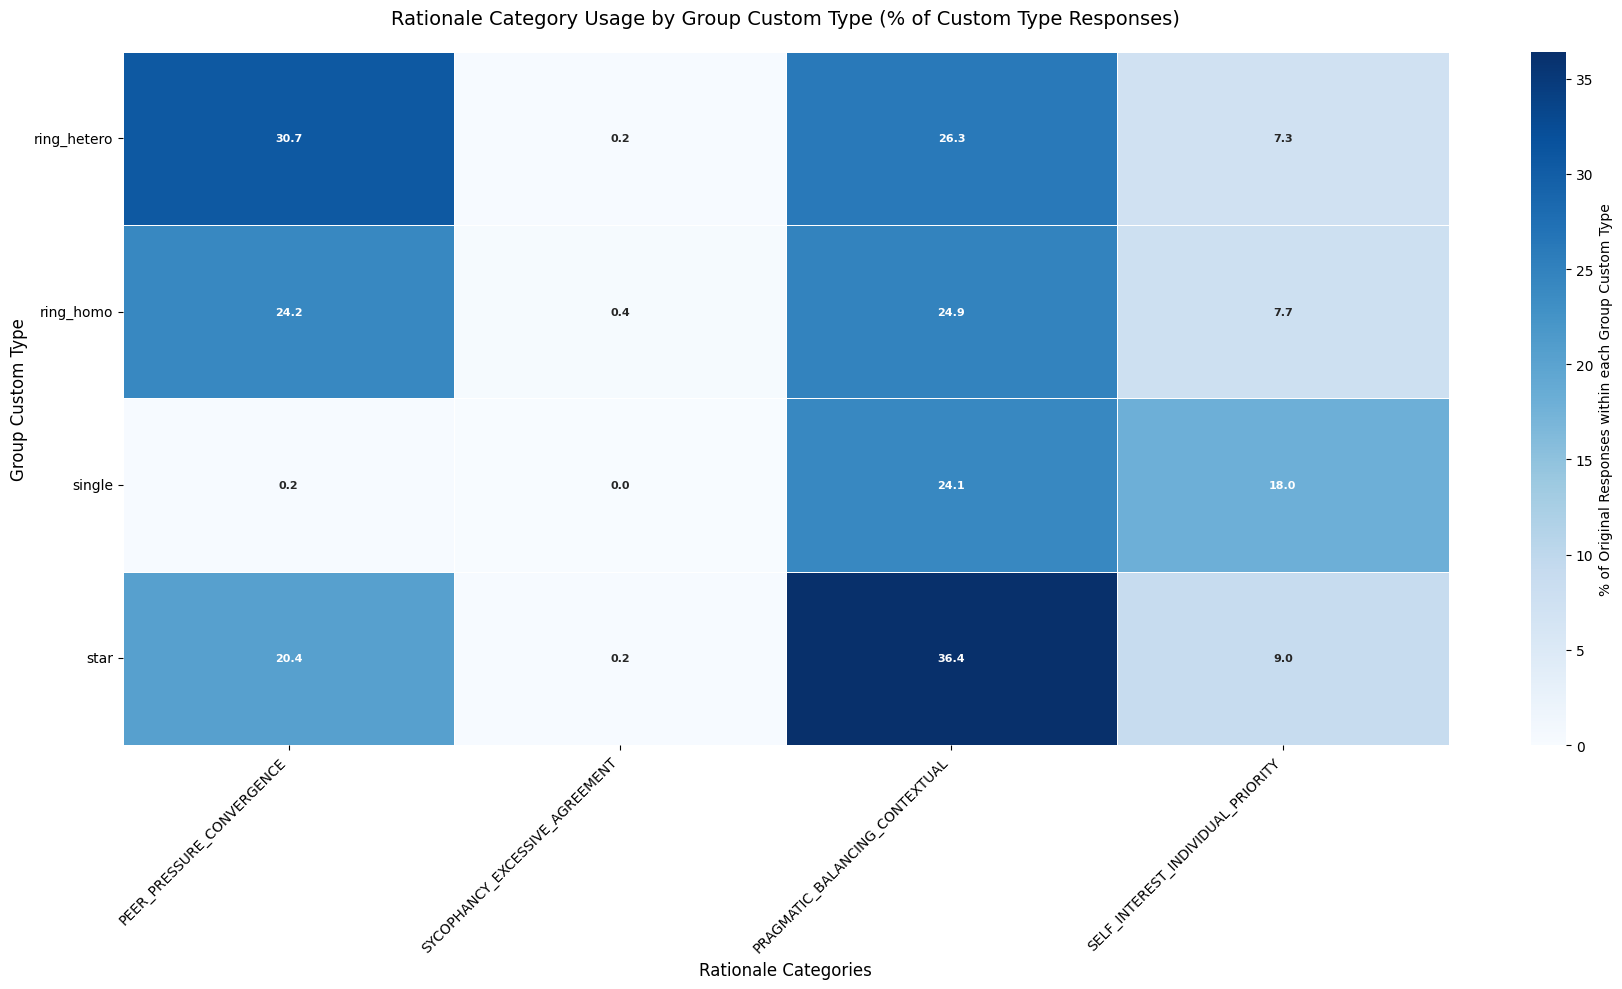

selected_categories,PEER_PRESSURE_CONVERGENCE,SYCOPHANCY_EXCESSIVE_AGREEMENT,PRAGMATIC_BALANCING_CONTEXTUAL,SELF_INTEREST_INDIVIDUAL_PRIORITY
group_custom_type,,,,
ring_hetero,30.653809,0.237223,26.287367,7.321119
ring_homo,24.153037,0.364098,24.878982,7.704283
single,0.162037,0.000000,24.074074,17.970679
star,20.436283,0.216339,36.413155,8.957453


In [49]:
# Generate heatmap split by group_custom_type
print("\n7. Category Usage by Group Custom Type (%)")
create_heatmap_with_dual_dfs(
    exploded_data_for_counts=custom_exploded_df,
    unexploded_df_for_group_totals=custom_combined_df,
    split_column='group_custom_type',
    title='Rationale Category Usage by Group Custom Type (% of Custom Type Responses)',
    cmap='Blues',
    figsize=(18, 10),
    ordered_categories=[
        "PEER_PRESSURE_CONVERGENCE",
        "SYCOPHANCY_EXCESSIVE_AGREEMENT",
        "PRAGMATIC_BALANCING_CONTEXTUAL",
        "SELF_INTEREST_INDIVIDUAL_PRIORITY",
    ]
)

# =============================================================================

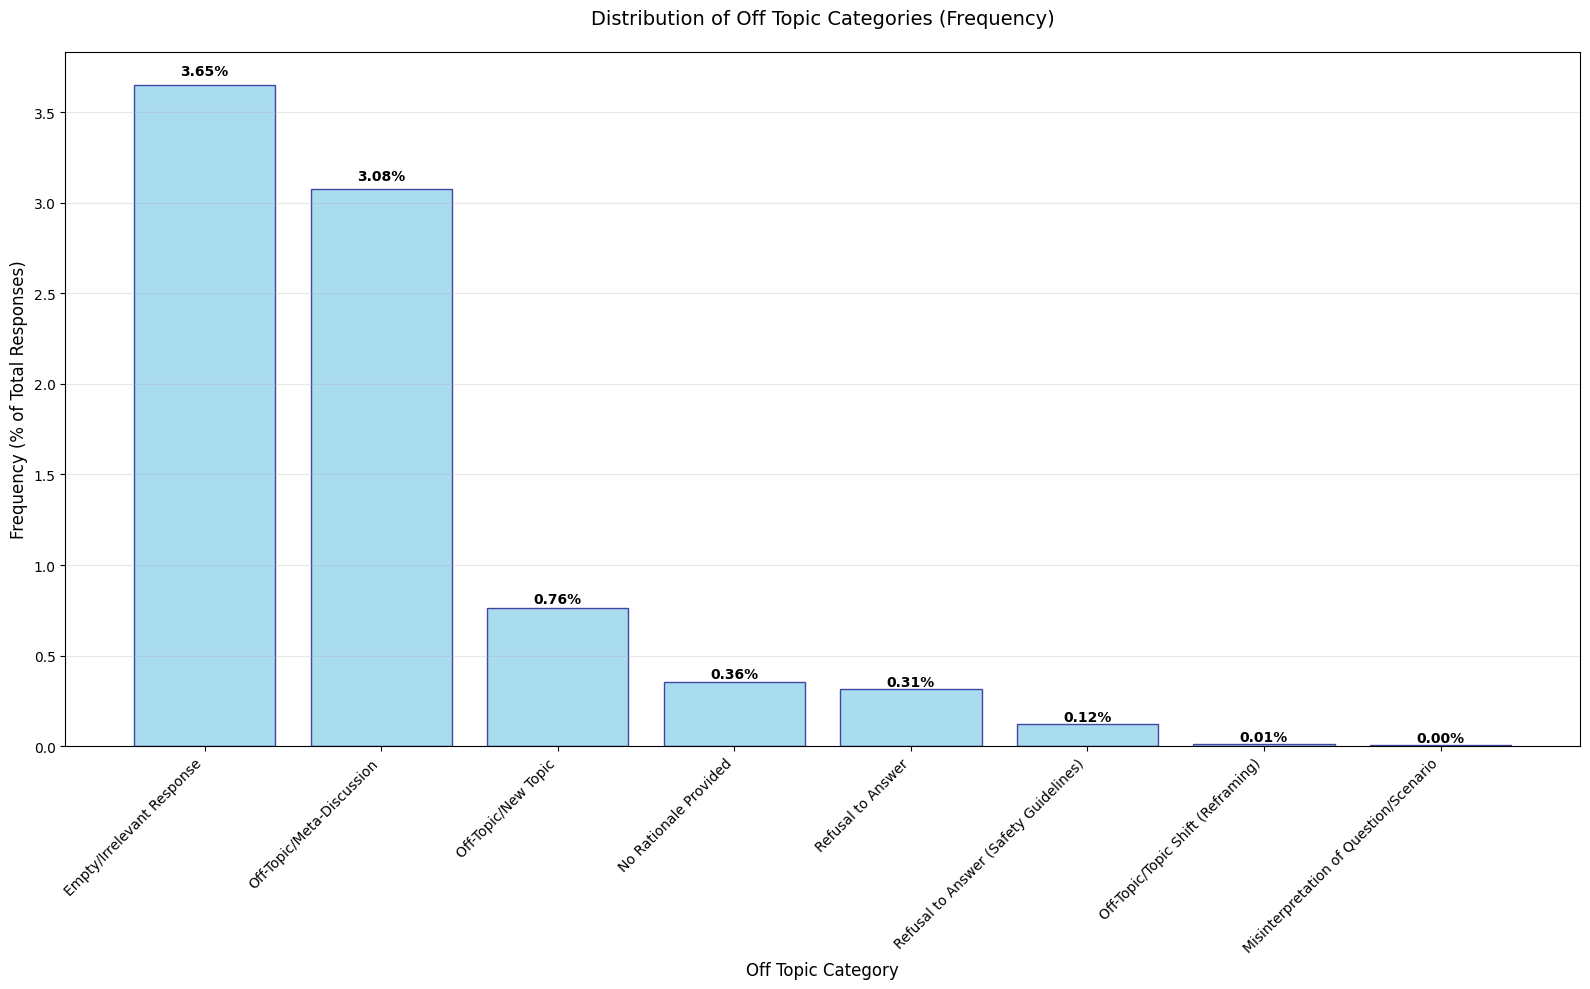


=== Off Topic Analysis Summary ===
Total responses: 470,640
Responses with off-topic categories: 39,079 (8.30%)
Number of unique off-topic categories: 8

=== Top 12 Off Topic Categories (Frequencies) ===
 1. Empty/Irrelevant Response: 3.65% (17,181 responses)
 2. Off-Topic/Meta-Discussion: 3.08% (14,478 responses)
 3. Off-Topic/New Topic: 0.76% (3,595 responses)
 4. No Rationale Provided: 0.36% (1,678 responses)
 5. Refusal to Answer: 0.31% (1,481 responses)
 6. Refusal to Answer (Safety Guidelines): 0.12% (579 responses)
 7. Off-Topic/Topic Shift (Reframing): 0.01% (66 responses)
 8. Misinterpretation of Question/Scenario: 0.00% (21 responses)

=== Major Category Types (Frequencies) ===
Meta-Discussion: 3.08% of total responses (37.0% of off-topic)
New Topic: 0.76% of total responses (9.2% of off-topic)
Empty/Irrelevant: 3.65% of total responses (44.0% of off-topic)
Refusal: 0.44% of total responses (5.3% of off-topic)
No Rationale: 0.36% of total responses (4.3% of off-topic)
Other:

In [50]:
import json
import os

# Load the classifications mapping
classifications_file = os.path.join(BASE_DIR, "classifications.json")
with open(classifications_file, 'r') as f:
    classifications_mapping = json.load(f)

# First, get the value counts to determine the mapping
off_topic_raw_counts = combined_df['off_topic_reason'].value_counts()

# Create a mapping from off_topic_reason values to classification categories
def map_off_topic_to_category(off_topic_reason):
    """Map off_topic_reason to standardized categories using the classifications.json"""
    if pd.isna(off_topic_reason) or off_topic_reason == '':
        return None
    
    # Try to find the reason in our classifications mapping using value_counts index + 1
    reason_str = str(off_topic_reason).strip()
    
    # Find the index of this reason in the value_counts and add 1
    try:
        reason_index = list(off_topic_raw_counts.index).index(reason_str) + 1
        classification_key = str(reason_index)
        return classifications_mapping.get(classification_key, f"Unknown Classification ({classification_key})")
    except ValueError:
        # If reason not found in value_counts, try direct lookup as before
        if reason_str.isdigit():
            return classifications_mapping.get(reason_str, "Unknown Classification")
        
        # If it's already a text description, try to find the best match
        for key, category in classifications_mapping.items():
            if reason_str.lower() == category.lower():
                return category
        
        # If no exact match, return the original reason
        return reason_str

# Apply the mapping to create standardized categories
combined_df['off_topic_category'] = combined_df['off_topic_reason'].apply(map_off_topic_to_category)

# Create histogram using the standardized categories
off_topic_category_counts = combined_df['off_topic_category'].value_counts()

# Filter out None values and get top categories for better visibility
off_topic_category_counts = off_topic_category_counts.dropna()
top_categories = off_topic_category_counts.head(12)  # Show top 12 categories

plt.figure(figsize=(16, 10))

# Calculate frequencies (percentages) instead of raw counts
total_responses = len(combined_df)
top_categories_freq = (top_categories / total_responses) * 100

bars = plt.bar(range(len(top_categories_freq)), top_categories_freq.values, color='skyblue', edgecolor='navy', alpha=0.7)
plt.xlabel('Off Topic Category', fontsize=12)
plt.ylabel('Frequency (% of Total Responses)', fontsize=12)
plt.title('Distribution of Off Topic Categories (Frequency)', fontsize=14, pad=20)
plt.xticks(range(len(top_categories_freq)), top_categories_freq.index, rotation=45, ha='right')

# Add value labels on top of bars showing percentages
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
             f'{height:.2f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.grid(axis='y', alpha=0.3)
plt.show()

# Print summary statistics
total_off_topic = len(combined_df[combined_df['off_topic_category'].notna()])
off_topic_percentage = (total_off_topic / total_responses) * 100

print(f"\n=== Off Topic Analysis Summary ===")
print(f"Total responses: {total_responses:,}")
print(f"Responses with off-topic categories: {total_off_topic:,} ({off_topic_percentage:.2f}%)")
print(f"Number of unique off-topic categories: {len(off_topic_category_counts)}")

print(f"\n=== Top 12 Off Topic Categories (Frequencies) ===")
for i, (category, freq) in enumerate(top_categories_freq.items(), 1):
    original_count = top_categories[category]
    print(f"{i:2d}. {category}: {freq:.2f}% ({original_count:,} responses)")

# Show breakdown by major category types with frequencies
print(f"\n=== Major Category Types (Frequencies) ===")
category_groups = {
    'Meta-Discussion': ['Off-Topic/Meta-Discussion'],
    'New Topic': ['Off-Topic/New Topic'],
    'Empty/Irrelevant': ['Empty/Irrelevant Response'],
    'Refusal': ['Refusal to Answer', 'Refusal to Answer (Safety Guidelines)'],
    'No Rationale': ['No Rationale Provided'],
    'Other': []  # Will catch remaining categories
}

for group_name, keywords in category_groups.items():
    if group_name == 'Other':
        # Count categories not in other groups
        other_categories = []
        for category in off_topic_category_counts.index:
            found_in_group = False
            for other_group, other_keywords in category_groups.items():
                if other_group != 'Other' and any(keyword in category for keyword in other_keywords):
                    found_in_group = True
                    break
            if not found_in_group:
                other_categories.append(category)
        group_count = sum(off_topic_category_counts[cat] for cat in other_categories if cat in off_topic_category_counts)
    else:
        group_count = sum(count for category, count in off_topic_category_counts.items() 
                         if any(keyword in category for keyword in keywords))
    
    group_frequency = (group_count / total_responses) * 100
    group_percentage_of_offtopic = (group_count / total_off_topic) * 100 if total_off_topic > 0 else 0
    print(f"{group_name}: {group_frequency:.2f}% of total responses ({group_percentage_of_offtopic:.1f}% of off-topic)")

In [51]:
combined_df['group_model'].unique()

array(['openai', 'google', 'deepseek', 'claude', 'llama', 'qwen', 'mixed'],
      dtype=object)

Creating three-row comparison heatmap...
Hetero data: 104627 exploded, 51850 combined
Star data: 59187 exploded, 25857 combined
OpenAI data: 103735 exploded, 51817 combined
Hetero data: 104627 exploded, 51850 combined
Star data: 59187 exploded, 25857 combined
OpenAI data: 103735 exploded, 51817 combined
Three-row comparison heatmap saved to /Users/ram/Github/wisdom_agents/heatmaps/three_row_comparison_heatmap_hetero_star_openai.png
Three-row comparison heatmap saved to /Users/ram/Github/wisdom_agents/heatmaps/three_row_comparison_heatmap_hetero_star_openai.png


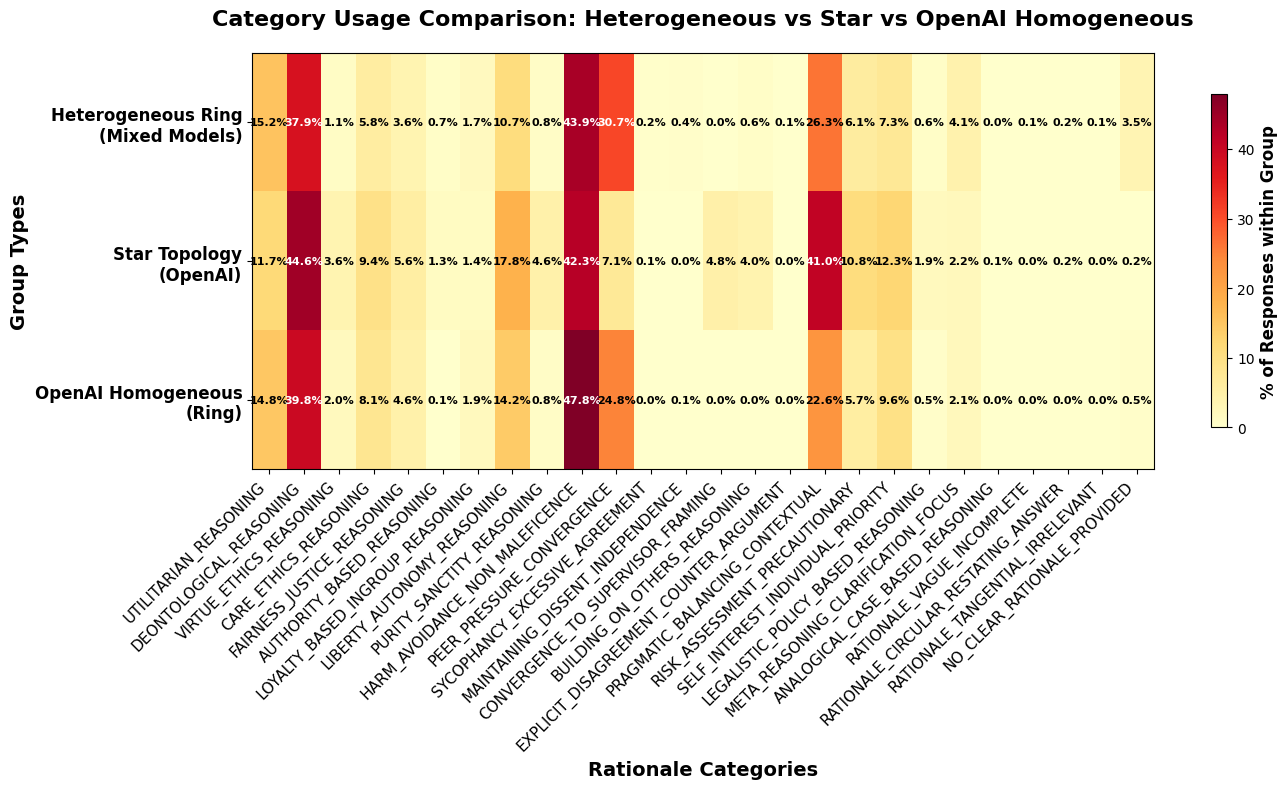


Creating alternative seaborn heatmap...
Seaborn heatmap saved to /Users/ram/Github/wisdom_agents/heatmaps/three_row_comparison_seaborn_heatmap.png
Seaborn heatmap saved to /Users/ram/Github/wisdom_agents/heatmaps/three_row_comparison_seaborn_heatmap.png


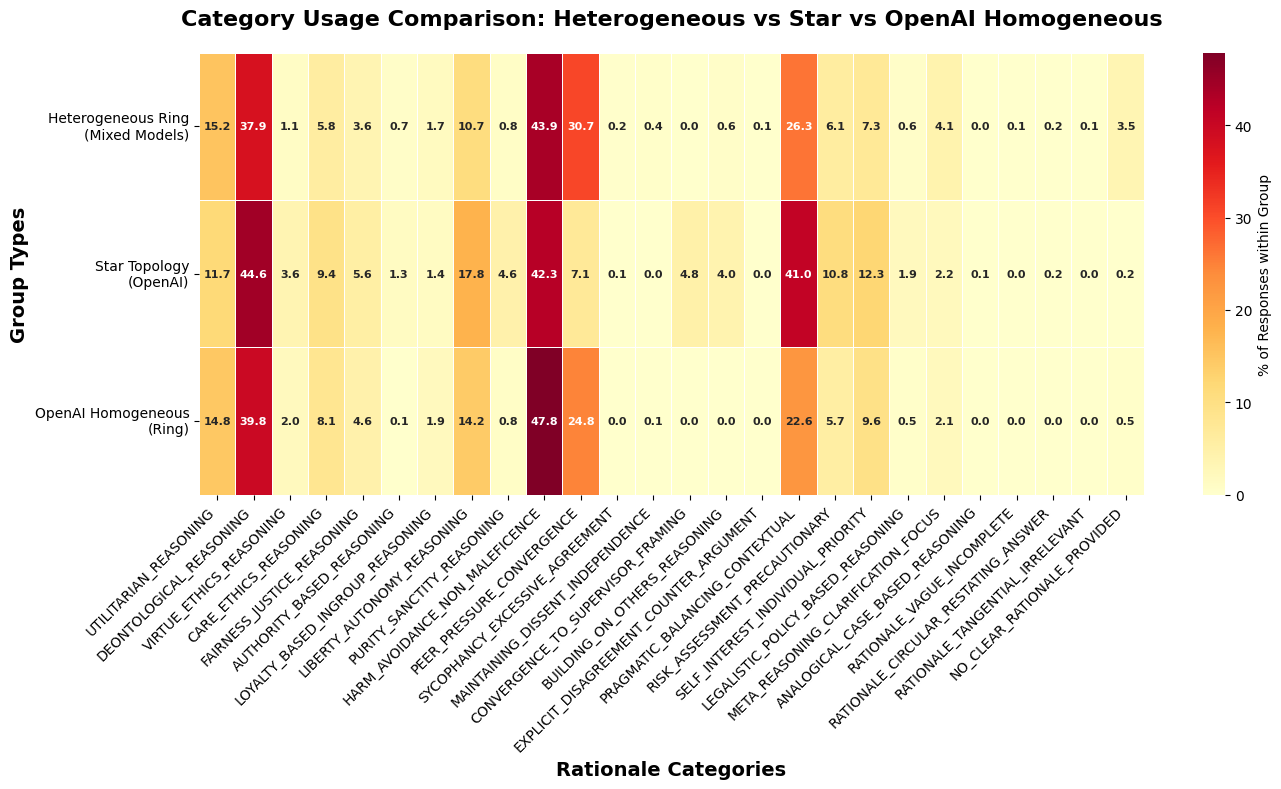


=== Summary Statistics ===
Heterogeneous Ring Groups: 51850 total responses
Star Topology Groups: 25857 total responses
OpenAI Homogeneous Groups: 51817 total responses

=== Key Findings ===
UTILITARIAN_REASONING:
  Hetero: 15.2%
  Star: 11.7%
  OpenAI: 14.8%
DEONTOLOGICAL_REASONING:
  Hetero: 37.9%
  Star: 44.6%
  OpenAI: 39.8%
VIRTUE_ETHICS_REASONING:
  Hetero: 1.1%
  Star: 3.6%
  OpenAI: 2.0%
CARE_ETHICS_REASONING:
  Hetero: 5.8%
  Star: 9.4%
  OpenAI: 8.1%
FAIRNESS_JUSTICE_REASONING:
  Hetero: 3.6%
  Star: 5.6%
  OpenAI: 4.6%
AUTHORITY_BASED_REASONING:
  Hetero: 0.7%
  Star: 1.3%
  OpenAI: 0.1%
LOYALTY_BASED_INGROUP_REASONING:
  Hetero: 1.7%
  Star: 1.4%
  OpenAI: 1.9%
LIBERTY_AUTONOMY_REASONING:
  Hetero: 10.7%
  Star: 17.8%
  OpenAI: 14.2%
PURITY_SANCTITY_REASONING:
  Hetero: 0.8%
  Star: 4.6%
  OpenAI: 0.8%
HARM_AVOIDANCE_NON_MALEFICENCE:
  Hetero: 43.9%
  Star: 42.3%
  OpenAI: 47.8%
PEER_PRESSURE_CONVERGENCE:
  Hetero: 30.7%
  Star: 7.1%
  OpenAI: 24.8%
SYCOPHANCY_EXCESSIVE_AG

In [52]:
# =============================================================================
# THREE-ROW COMPARISON: HETERO vs STAR vs OPENAI HOMO - HEATMAP VERSION
# =============================================================================

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Filter data for the three comparison groups
print("Creating three-row comparison heatmap...")

# 1. Heterogeneous ring groups (mixed models)
hetero_exploded = exploded_df[
    (exploded_df['group_type'] == 'ring') & 
    (exploded_df['group_model'] == 'mixed') &
    (exploded_df['group_evil'] == False)
]
hetero_combined = combined_df[
    (combined_df['group_type'] == 'ring') & 
    (combined_df['group_model'] == 'mixed') &
    (combined_df['group_evil'] == False)
]

# 2. Star topology (non-evil, non-inverted, homogeneous)
star_exploded = exploded_df[
    (exploded_df['group_type'] == 'star') & 
    (exploded_df['group_evil'] == False) &
    (exploded_df['group_inverted'] == False) &
    (exploded_df['group_model'] == 'openai')
]
star_combined = combined_df[
    (combined_df['group_type'] == 'star') & 
    (combined_df['group_evil'] == False) &
    (combined_df['group_inverted'] == False) &
    (combined_df['group_model'] == 'openai')
]

# 3. OpenAI homogeneous groups (single + ring homo)
openai_exploded = exploded_df[
    (
     ((exploded_df['group_type'] == 'ring') & (exploded_df['group_model'] != 'mixed'))) &
    (exploded_df['group_model'] == 'openai') &
    (exploded_df['group_evil'] == False)
]
openai_combined = combined_df[
    (
     ((combined_df['group_type'] == 'ring') & (combined_df['group_model'] != 'mixed'))) &
    (combined_df['group_model'] == 'openai') &
    (combined_df['group_evil'] == False)
]

print(f"Hetero data: {len(hetero_exploded)} exploded, {len(hetero_combined)} combined")
print(f"Star data: {len(star_exploded)} exploded, {len(star_combined)} combined")
print(f"OpenAI data: {len(openai_exploded)} exploded, {len(openai_combined)} combined")

# Key categories for focused comparison
key_categories = VALID_CATEGORY_NAMES

def calculate_category_percentages(exploded_data, combined_data, categories):
    """Calculate percentage usage for each category"""
    if combined_data.empty:
        return {}
    
    total_responses = len(combined_data)
    percentages = {}
    
    for category in categories:
        category_count = len(exploded_data[exploded_data['selected_categories'] == category])
        percentages[category] = (category_count / total_responses) * 100
    
    return percentages

# Calculate percentages for each group
hetero_pct = calculate_category_percentages(hetero_exploded, hetero_combined, key_categories)
star_pct = calculate_category_percentages(star_exploded, star_combined, key_categories)
openai_pct = calculate_category_percentages(openai_exploded, openai_combined, key_categories)

# Create data matrix for heatmap
data_matrix = np.array([
    [hetero_pct.get(cat, 0) for cat in key_categories],
    [star_pct.get(cat, 0) for cat in key_categories],
    [openai_pct.get(cat, 0) for cat in key_categories]
])

# Create row and column labels
row_labels = ['Heterogeneous Ring\n(Mixed Models)', 'Star Topology\n(OpenAI)', 'OpenAI Homogeneous\n(Ring)']
col_labels = VALID_CATEGORY_NAMES

# Create the heatmap
fig, ax = plt.subplots(figsize=(14, 8))

# Create heatmap with custom colormap
heatmap = ax.imshow(data_matrix, cmap='YlOrRd', aspect='auto', interpolation='nearest')

# Set ticks and labels
ax.set_xticks(np.arange(len(key_categories)))
ax.set_yticks(np.arange(len(row_labels)))
ax.set_xticklabels(col_labels, rotation=45, ha='right', fontsize=11)
ax.set_yticklabels(row_labels, fontsize=12, fontweight='bold')

# Calculate font size based on cell dimensions
cell_width = 14 / len(key_categories)  # figsize width / number of columns
cell_height = 8 / len(row_labels)      # figsize height / number of rows
text_font_size = max(8, min(18, min(cell_width * 1.5, cell_height * 2)))

# Add text annotations with percentages
for i in range(len(row_labels)):
    for j in range(len(key_categories)):
        value = data_matrix[i, j]
        color = 'white' if value > data_matrix.max() * 0.6 else 'black'
        ax.text(j, i, f'{value:.1f}%', ha='center', va='center', 
                fontsize=text_font_size, fontweight='bold', color=color)

# Add colorbar
cbar = plt.colorbar(heatmap, ax=ax, shrink=0.8)
cbar.set_label('% of Responses within Group', fontsize=12, fontweight='bold')
cbar.ax.tick_params(labelsize=10)

# Set title and layout
plt.title('Category Usage Comparison: Heterogeneous vs Star vs OpenAI Homogeneous', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Rationale Categories', fontsize=14, fontweight='bold')
plt.ylabel('Group Types', fontsize=14, fontweight='bold')

# Adjust layout
plt.tight_layout()

# Save the heatmap
output_dir = os.path.join(BASE_DIR, "heatmaps")
os.makedirs(output_dir, exist_ok=True)
output_file = os.path.join(output_dir, "three_row_comparison_heatmap_hetero_star_openai.png")
plt.savefig(output_file, dpi=300, bbox_inches='tight')
print(f"Three-row comparison heatmap saved to {output_file}")

plt.show()

# Alternative version using seaborn for more polished appearance
print("\nCreating alternative seaborn heatmap...")

# Create DataFrame for seaborn
import pandas as pd
heatmap_df = pd.DataFrame(
    data_matrix,
    index=row_labels,
    columns=col_labels
)

# Calculate font size for seaborn heatmap
num_rows, num_cols = heatmap_df.shape
seaborn_font_size = max(8, min(16, min(14 / num_cols * 1.8, 8 / num_rows * 2.5)))

# Create seaborn heatmap
fig, ax = plt.subplots(figsize=(14, 8))
sns.heatmap(heatmap_df, 
            annot=True, 
            fmt='.1f', 
            cmap='YlOrRd',
            cbar_kws={'label': '% of Responses within Group'},
            linewidths=0.5,
            annot_kws={'size': seaborn_font_size, 'weight': 'bold'},
            ax=ax)

plt.title('Category Usage Comparison: Heterogeneous vs Star vs OpenAI Homogeneous', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Rationale Categories', fontsize=14, fontweight='bold')
plt.ylabel('Group Types', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

# Save the seaborn version
output_file_sns = os.path.join(output_dir, "three_row_comparison_seaborn_heatmap.png")
plt.savefig(output_file_sns, dpi=300, bbox_inches='tight')
print(f"Seaborn heatmap saved to {output_file_sns}")

plt.show()

# Print summary statistics
print("\n=== Summary Statistics ===")
print(f"Heterogeneous Ring Groups: {len(hetero_combined)} total responses")
print(f"Star Topology Groups: {len(star_combined)} total responses") 
print(f"OpenAI Homogeneous Groups: {len(openai_combined)} total responses")

print("\n=== Key Findings ===")
for i, category in enumerate(key_categories):
    print(f"{col_labels[i]}:")
    print(f"  Hetero: {hetero_pct.get(category, 0):.1f}%")
    print(f"  Star: {star_pct.get(category, 0):.1f}%") 
    print(f"  OpenAI: {openai_pct.get(category, 0):.1f}%")

# Show the data matrix for reference
print(f"\n=== Data Matrix ===")
print("Rows: {0}".format(row_labels))
print("Columns: {0}".format(col_labels))
print(data_matrix)

Creating three-row comparison heatmap for Qwen...
Hetero data: 104627 exploded, 51850 combined
Star data: 56052 exploded, 25956 combined
Qwen data: 93930 exploded, 51610 combined
Hetero data: 104627 exploded, 51850 combined
Star data: 56052 exploded, 25956 combined
Qwen data: 93930 exploded, 51610 combined
Three-row comparison heatmap saved to /Users/ram/Github/wisdom_agents/heatmaps/three_row_comparison_heatmap_hetero_star_qwen.png
Three-row comparison heatmap saved to /Users/ram/Github/wisdom_agents/heatmaps/three_row_comparison_heatmap_hetero_star_qwen.png


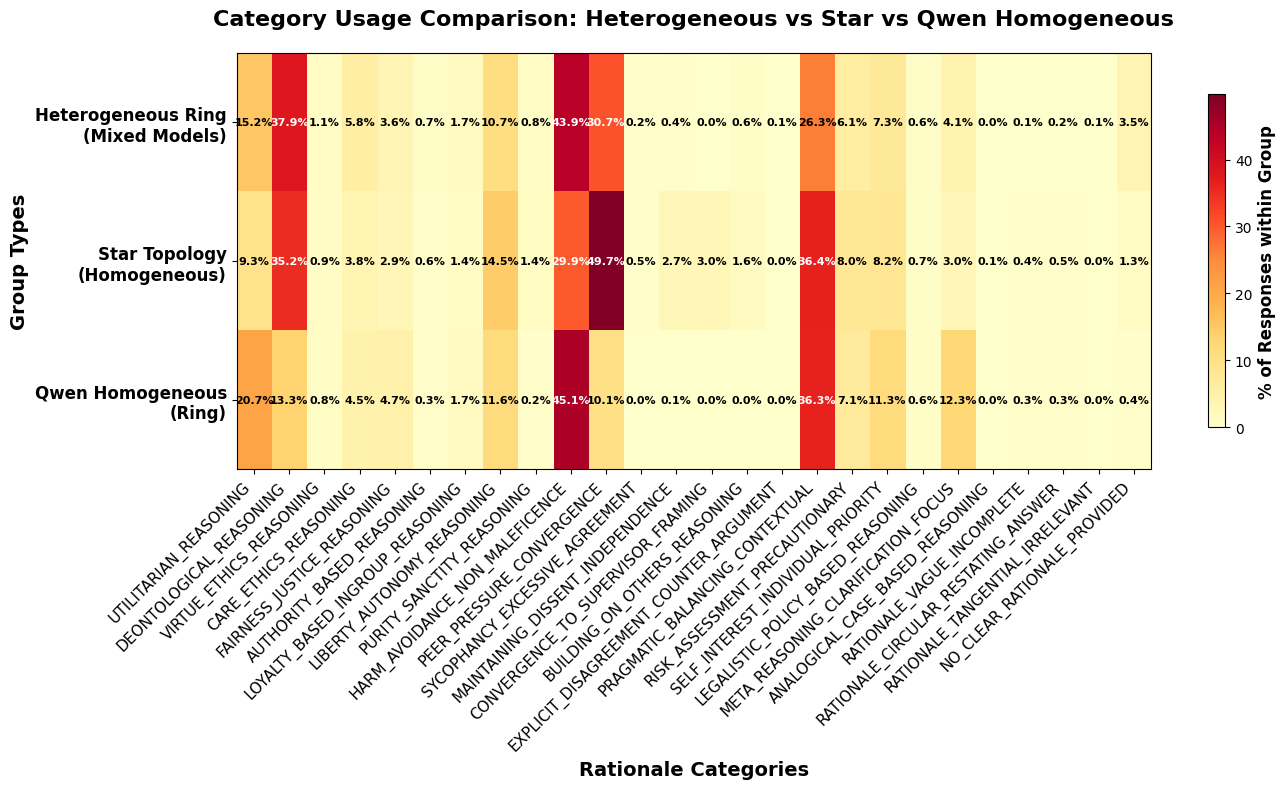


Creating alternative seaborn heatmap...
Seaborn heatmap saved to /Users/ram/Github/wisdom_agents/heatmaps/three_row_comparison_seaborn_heatmap_qwen.png
Seaborn heatmap saved to /Users/ram/Github/wisdom_agents/heatmaps/three_row_comparison_seaborn_heatmap_qwen.png


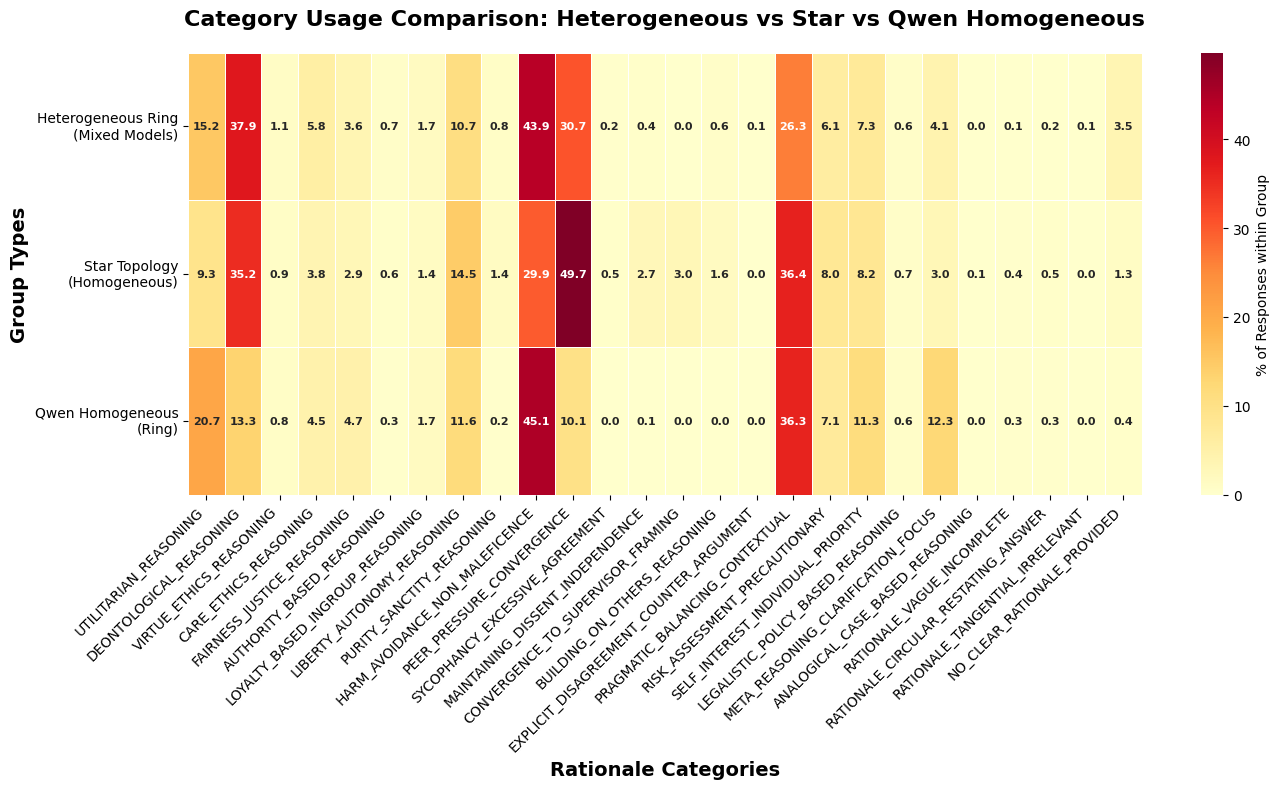


=== Summary Statistics ===
Heterogeneous Ring Groups: 51850 total responses
Star Topology Groups: 25956 total responses
Qwen Homogeneous Groups: 51610 total responses

=== Key Findings ===
UTILITARIAN_REASONING:
  Hetero: 15.2%
  Star: 9.3%
  Qwen: 20.7%
DEONTOLOGICAL_REASONING:
  Hetero: 37.9%
  Star: 35.2%
  Qwen: 13.3%
VIRTUE_ETHICS_REASONING:
  Hetero: 1.1%
  Star: 0.9%
  Qwen: 0.8%
CARE_ETHICS_REASONING:
  Hetero: 5.8%
  Star: 3.8%
  Qwen: 4.5%
FAIRNESS_JUSTICE_REASONING:
  Hetero: 3.6%
  Star: 2.9%
  Qwen: 4.7%
AUTHORITY_BASED_REASONING:
  Hetero: 0.7%
  Star: 0.6%
  Qwen: 0.3%
LOYALTY_BASED_INGROUP_REASONING:
  Hetero: 1.7%
  Star: 1.4%
  Qwen: 1.7%
LIBERTY_AUTONOMY_REASONING:
  Hetero: 10.7%
  Star: 14.5%
  Qwen: 11.6%
PURITY_SANCTITY_REASONING:
  Hetero: 0.8%
  Star: 1.4%
  Qwen: 0.2%
HARM_AVOIDANCE_NON_MALEFICENCE:
  Hetero: 43.9%
  Star: 29.9%
  Qwen: 45.1%
PEER_PRESSURE_CONVERGENCE:
  Hetero: 30.7%
  Star: 49.7%
  Qwen: 10.1%
SYCOPHANCY_EXCESSIVE_AGREEMENT:
  Hetero: 0.2%


In [53]:
# =============================================================================
# THREE-ROW COMPARISON: HETERO vs STAR vs QWEN HOMO - HEATMAP VERSION
# =============================================================================

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Filter data for the three comparison groups
print("Creating three-row comparison heatmap for Qwen...")

# 1. Heterogeneous ring groups (mixed models)
hetero_exploded = exploded_df[
    (exploded_df['group_type'] == 'ring') & 
    (exploded_df['group_model'] == 'mixed') &
    (exploded_df['group_evil'] == False)
]
hetero_combined = combined_df[
    (combined_df['group_type'] == 'ring') & 
    (combined_df['group_model'] == 'mixed') &
    (combined_df['group_evil'] == False)
]

# 2. Star topology (non-evil, non-inverted, homogeneous)
star_exploded = exploded_df[
    (exploded_df['group_type'] == 'star') & 
    (exploded_df['group_evil'] == False) &
    (exploded_df['group_inverted'] == False) &
    (exploded_df['group_model'] == 'qwen')
]
star_combined = combined_df[
    (combined_df['group_type'] == 'star') & 
    (combined_df['group_evil'] == False) &
    (combined_df['group_inverted'] == False) &
    (combined_df['group_model'] == 'qwen')
]

# 3. Qwen homogeneous groups (single + ring homo)
qwen_exploded = exploded_df[
    (
     ((exploded_df['group_type'] == 'ring') & (exploded_df['group_model'] != 'mixed'))) &
    (exploded_df['group_model'] == 'qwen') &
    (exploded_df['group_evil'] == False)
]
qwen_combined = combined_df[
    (
     ((combined_df['group_type'] == 'ring') & (combined_df['group_model'] != 'mixed'))) &
    (combined_df['group_model'] == 'qwen') &
    (combined_df['group_evil'] == False)
]

print(f"Hetero data: {len(hetero_exploded)} exploded, {len(hetero_combined)} combined")
print(f"Star data: {len(star_exploded)} exploded, {len(star_combined)} combined")
print(f"Qwen data: {len(qwen_exploded)} exploded, {len(qwen_combined)} combined")

# Key categories for focused comparison
key_categories = VALID_CATEGORY_NAMES

def calculate_category_percentages(exploded_data, combined_data, categories):
    """Calculate percentage usage for each category"""
    if combined_data.empty:
        return {}
    
    total_responses = len(combined_data)
    percentages = {}
    
    for category in categories:
        category_count = len(exploded_data[exploded_data['selected_categories'] == category])
        percentages[category] = (category_count / total_responses) * 100
    
    return percentages

# Calculate percentages for each group
hetero_pct = calculate_category_percentages(hetero_exploded, hetero_combined, key_categories)
star_pct = calculate_category_percentages(star_exploded, star_combined, key_categories)
qwen_pct = calculate_category_percentages(qwen_exploded, qwen_combined, key_categories)

# Create data matrix for heatmap
data_matrix = np.array([
    [hetero_pct.get(cat, 0) for cat in key_categories],
    [star_pct.get(cat, 0) for cat in key_categories],
    [qwen_pct.get(cat, 0) for cat in key_categories]
])

# Create row and column labels
row_labels = ['Heterogeneous Ring\n(Mixed Models)', 'Star Topology\n(Homogeneous)', 'Qwen Homogeneous\n(Ring)']
col_labels = VALID_CATEGORY_NAMES

# Create the heatmap
fig, ax = plt.subplots(figsize=(14, 8))

# Create heatmap with custom colormap
heatmap = ax.imshow(data_matrix, cmap='YlOrRd', aspect='auto', interpolation='nearest')

# Set ticks and labels
ax.set_xticks(np.arange(len(key_categories)))
ax.set_yticks(np.arange(len(row_labels)))
ax.set_xticklabels(col_labels, rotation=45, ha='right', fontsize=11)
ax.set_yticklabels(row_labels, fontsize=12, fontweight='bold')

# Calculate font size based on cell dimensions
cell_width = 14 / len(key_categories)  # figsize width / number of columns
cell_height = 8 / len(row_labels)      # figsize height / number of rows
text_font_size = max(8, min(18, min(cell_width * 1.5, cell_height * 2)))

# Add text annotations with percentages
for i in range(len(row_labels)):
    for j in range(len(key_categories)):
        value = data_matrix[i, j]
        color = 'white' if value > data_matrix.max() * 0.6 else 'black'
        ax.text(j, i, f'{value:.1f}%', ha='center', va='center', 
                fontsize=text_font_size, fontweight='bold', color=color)

# Add colorbar
cbar = plt.colorbar(heatmap, ax=ax, shrink=0.8)
cbar.set_label('% of Responses within Group', fontsize=12, fontweight='bold')
cbar.ax.tick_params(labelsize=10)

# Set title and layout
plt.title('Category Usage Comparison: Heterogeneous vs Star vs Qwen Homogeneous', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Rationale Categories', fontsize=14, fontweight='bold')
plt.ylabel('Group Types', fontsize=14, fontweight='bold')

# Adjust layout
plt.tight_layout()

# Save the heatmap
output_dir = os.path.join(BASE_DIR, "heatmaps")
os.makedirs(output_dir, exist_ok=True)
output_file = os.path.join(output_dir, "three_row_comparison_heatmap_hetero_star_qwen.png")
plt.savefig(output_file, dpi=300, bbox_inches='tight')
print(f"Three-row comparison heatmap saved to {output_file}")

plt.show()

# Alternative version using seaborn for more polished appearance
print("\nCreating alternative seaborn heatmap...")

# Create DataFrame for seaborn
import pandas as pd
heatmap_df = pd.DataFrame(
    data_matrix,
    index=row_labels,
    columns=col_labels
)

# Calculate font size for seaborn heatmap
num_rows, num_cols = heatmap_df.shape
seaborn_font_size = max(8, min(16, min(14 / num_cols * 1.8, 8 / num_rows * 2.5)))

# Create seaborn heatmap
fig, ax = plt.subplots(figsize=(14, 8))
sns.heatmap(heatmap_df, 
            annot=True, 
            fmt='.1f', 
            cmap='YlOrRd',
            cbar_kws={'label': '% of Responses within Group'},
            linewidths=0.5,
            annot_kws={'size': seaborn_font_size, 'weight': 'bold'},
            ax=ax)

plt.title('Category Usage Comparison: Heterogeneous vs Star vs Qwen Homogeneous', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Rationale Categories', fontsize=14, fontweight='bold')
plt.ylabel('Group Types', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

# Save the seaborn version
output_file_sns = os.path.join(output_dir, "three_row_comparison_seaborn_heatmap_qwen.png")
plt.savefig(output_file_sns, dpi=300, bbox_inches='tight')
print(f"Seaborn heatmap saved to {output_file_sns}")

plt.show()

# Print summary statistics
print("\n=== Summary Statistics ===")
print(f"Heterogeneous Ring Groups: {len(hetero_combined)} total responses")
print(f"Star Topology Groups: {len(star_combined)} total responses") 
print(f"Qwen Homogeneous Groups: {len(qwen_combined)} total responses")

print("\n=== Key Findings ===")
for i, category in enumerate(key_categories):
    print(f"{col_labels[i]}:")
    print(f"  Hetero: {hetero_pct.get(category, 0):.1f}%")
    print(f"  Star: {star_pct.get(category, 0):.1f}%") 
    print(f"  Qwen: {qwen_pct.get(category, 0):.1f}%")

# Show the data matrix for reference
print(f"\n=== Data Matrix ===")
print("Rows: {0}".format(row_labels))
print("Columns: {0}".format(col_labels))
print(data_matrix)